In [1]:
from astropy.table import Table, vstack, Column
from tqdm import tqdm
from astropy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.lines import Line2D
import warnings

In [2]:
decals_raw_k_corrected = Table.read('K_corrected_decals_data_mag_errors.csv', format='ascii')
decals_raw = Table.read('GalfitM_DECALS_207.csv', format='ascii')
decals = decals_raw[decals_raw['type'] != 'PSF']
decals_k_corrected = decals_raw_k_corrected[decals_raw_k_corrected['type'] != 'PSF']
control_sample = Table.read('K_corrected_control_sample_mag_errors.csv', format='ascii')

# Convertir la tabla de astropy a un DataFrame de pandas
df = decals.to_pandas()
df2 = decals_k_corrected.to_pandas()
# Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals = Table.from_pandas(df)
decals_k_corrected = Table.from_pandas(df2)

In [3]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')
    control_sample['n_' + filtro] = pd.to_numeric(control_sample['n_' + filtro], errors='coerce')
    control_sample['e_mag_' + filtro] = pd.to_numeric(control_sample['e_mag_' + filtro], errors='coerce')
    control_sample['RE_' +filtro] = pd.to_numeric(control_sample['RE_' + filtro], errors = 'coerce')
    control_sample['e_n_' + filtro] = pd.to_numeric(control_sample['e_n_' + filtro], errors='coerce')
    control_sample['e_RE_' +filtro] = pd.to_numeric(control_sample['e_RE_' + filtro], errors = 'coerce')
    decals_k_corrected['n_' + filtro] = pd.to_numeric(decals_k_corrected['n_' + filtro], errors='coerce')
    decals_k_corrected['RE_' +filtro] = pd.to_numeric(decals_k_corrected['RE_' + filtro], errors = 'coerce')
    decals_k_corrected['e_n_' + filtro] = pd.to_numeric(decals_k_corrected['e_n_' + filtro], errors='coerce')
    decals_k_corrected['e_RE_' +filtro] = pd.to_numeric(decals_k_corrected['e_RE_' + filtro], errors = 'coerce')

In [4]:
print(len(decals))
print(len(decals_k_corrected))

770
559


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


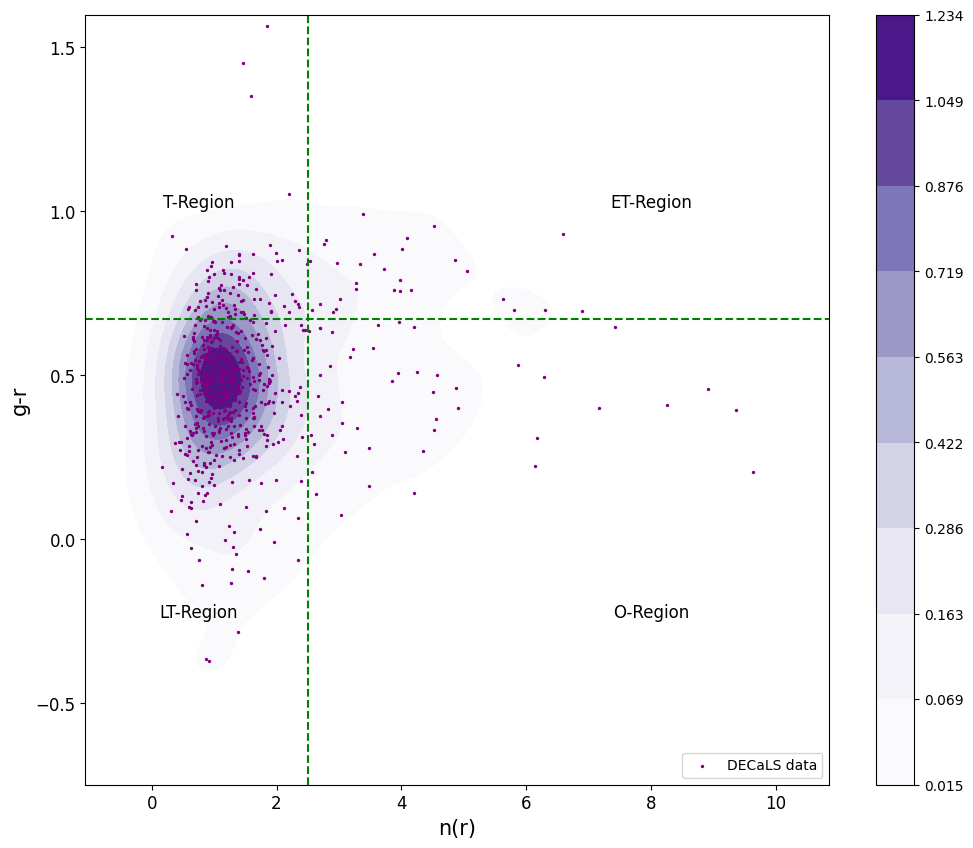

727


In [5]:
decals_no_zero = decals[decals['n_r']!=0.0]
g_r_decals = decals_no_zero['mag_g'] - decals_no_zero['mag_r']
n_r = decals_no_zero['n_r']
cs_no_zero = control_sample[control_sample['n_r'] != 0.0]
g_r_cs = cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']
n_r_cs = cs_no_zero['n_r']

plt.figure(figsize=(12, 10))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Purples', fill=True, cbar=True)

plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='DECaLS data', s=8, color='purple')

plt.ylim(-0.75, 1.6)
#plt.xlim(0, )
plt.xticks(size=12)
plt.yticks(size=12)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('g-r', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right')
plt.axhline(y=0.67, color='green', linestyle='--')

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='green', linestyle='--')

# Agregar texto en coordenadas específicas
plt.text(0.75, 1, 'T-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=12, ha='center', va='bottom', color='black')

plt.show()
print(len(decals_no_zero))

/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


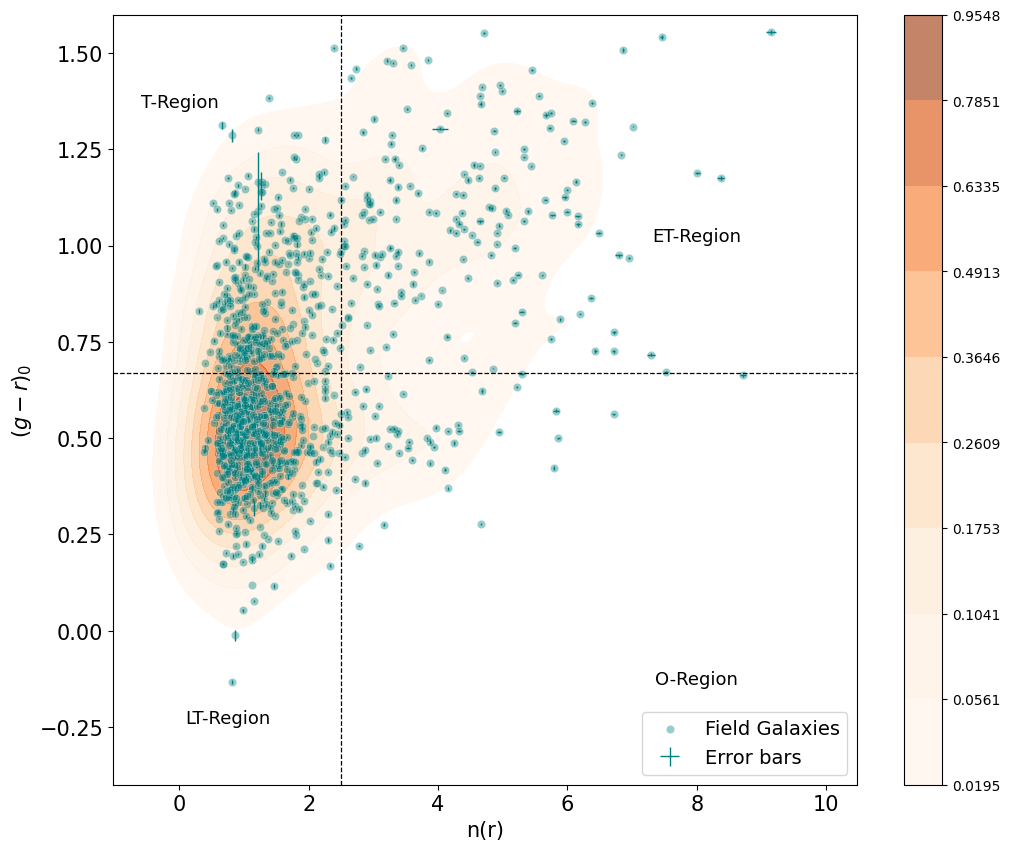

1097
0.6182621222171072


In [6]:
median_error = np.mean(cs_no_zero['e_mag_g']+cs_no_zero['e_mag_r'])

plt.figure(figsize=(12, 10))

sns.kdeplot(x=n_r_cs, y=g_r_cs, cmap='Oranges', alpha = 0.6, fill=True, cbar=True)

sns.scatterplot(data=cs_no_zero, x=cs_no_zero['n_r'], y=g_r_cs, color='teal', alpha=0.4, label='Field Galaxies')

plt.errorbar(cs_no_zero['n_r'], g_r_cs, xerr= cs_no_zero['e_n_r'],
             yerr=(cs_no_zero['e_mag_r']+cs_no_zero['e_mag_g']), fmt='None',
             color='teal', lw=1, label='Error bars')

plt.ylim(-0.4, 1.6)
plt.xticks(size=15)
plt.yticks(size=15)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)

# Añadir una línea horizontal en y=50
plt.legend(loc='lower right', fontsize=14)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)

# Agregar texto en coordenadas específicas
plt.text(0, 1.35, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, -0.15, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

plt.show()
print(len(cs_no_zero))
print(np.median(g_r_cs))

/home/seba/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


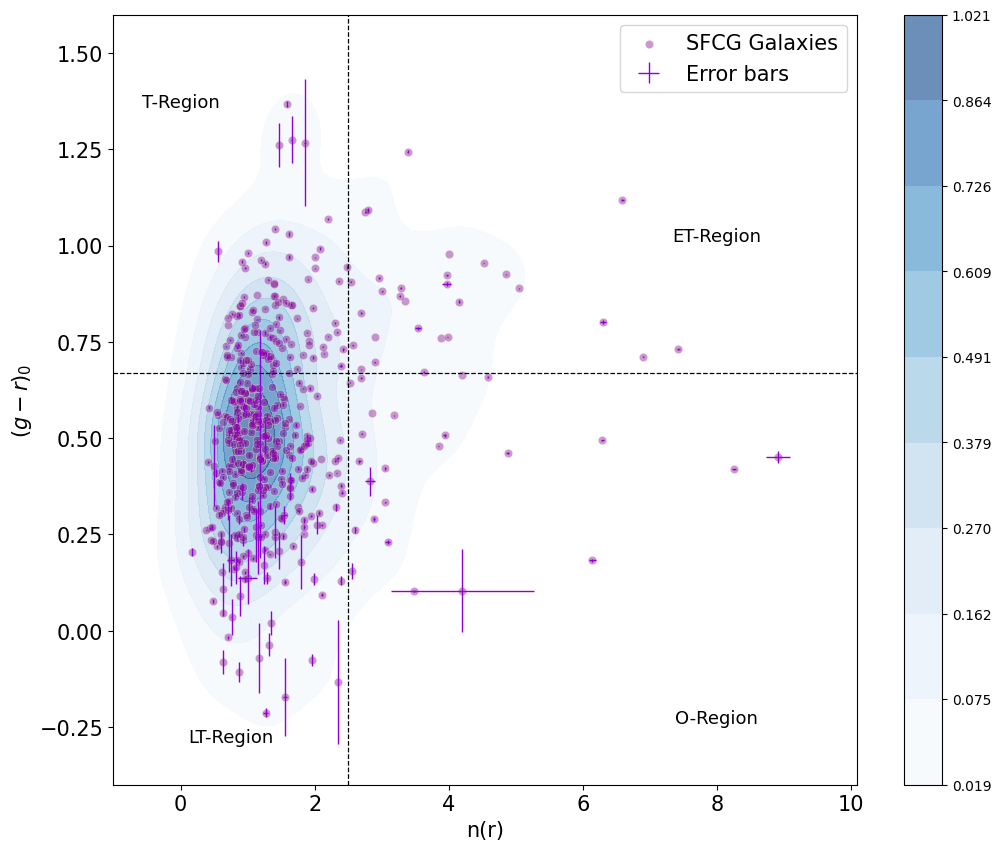

0.008316606305496783
473
0.5130374353805163


In [7]:
mask = [
    isinstance(value_g, (int, float)) and isinstance(value_r, (int, float))
    for value_g, value_r in zip(decals_k_corrected['m_g_corrected'], decals_k_corrected['m_r_corrected'])
]# Aplicamos la máscara para filtrar la tabla
decals_no_zero = decals_k_corrected[mask]
decals_no_zero = decals_no_zero[decals_no_zero['n_r']!=0.0]
decals_no_zero = decals_no_zero[decals_no_zero['e_n_r'] < 2]
g_r_decals = decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']
n_r = decals_no_zero['n_r']
cs_no_zero = control_sample[control_sample['n_r'] != 0.0]
g_r_cs = cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']
n_r_cs = cs_no_zero['n_r']
median_color = np.nanmedian(g_r_decals)
plt.figure(figsize=(12, 10))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', alpha=0.6, fill=True, cbar=True)

sns.scatterplot(data=decals_no_zero, x=decals_no_zero['n_r'], y=g_r_decals, color='purple', alpha=0.4, label='SFCG Galaxies')

plt.errorbar(decals_no_zero['n_r'], g_r_decals, xerr= decals_no_zero['e_n_r'], 
             yerr=(decals_no_zero['e_mag_r']+decals_no_zero['e_mag_g']), fmt='None', 
             color='darkviolet', lw=1, label='Error bars')

mean_error = np.mean(decals_no_zero['e_mag_r']+decals_no_zero['e_mag_g'])

plt.ylim(-0.4, 1.6)
#plt.xlim(0, )
plt.xticks(size=15)
plt.yticks(size=15)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='upper right', fontsize=15)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)

# Agregar texto en coordenadas específicas
plt.text(0, 1.35, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.3, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

plt.show()
print(mean_error)
print(len(decals_no_zero))

valid = []
for dato in g_r_decals:
    if isinstance(dato, (int, float)):
        valid.append(dato)
print(np.median(valid))

In [8]:
decals_no_zero[decals_no_zero['e_n_r']>0.5]

<Table length=1>
      e_mag_g             e_mag_r       ...   FUV_corrected     NUV_corrected   
      float64             float64       ...      float64           float64      
------------------- ------------------- ... ----------------- ------------------
0.04692491780456689 0.06060282655734013 ... 19.56356260103984 19.535263112839715

In [9]:
late_type_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) <= 0.67) & (decals_no_zero['n_r'] <= 2.5)]
transition_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) > 0.67) & (decals_no_zero['n_r'] <= 2.5)]
early_type_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) >= 0.67) & (decals_no_zero['n_r'] > 2.5)]
other_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) < 0.67) & (decals_no_zero['n_r'] > 2.5)]
print(len(late_type_sfcg), len(transition_sfcg), len(early_type_sfcg), len(other_sfcg), len(decals_no_zero))
#transition = transition[(transition['n_r'] != 0.0) & (transition['RE_r(kpc)'] != 0.0)]

310 109 30 24 473


In [10]:
late_type_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) < 0.67) & (cs_no_zero['n_r'] <= 2.5)]
transition_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) > 0.67) & (cs_no_zero['n_r'] <= 2.5)]
early_type_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) > 0.67) & (cs_no_zero['n_r'] > 2.5)]
other_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) < 0.67) & (cs_no_zero['n_r'] > 2.5)]
#print(len(late_type), len(transition), len(early_type), len(other))

In [11]:
# Función para calcular el error mediante bootstrapping en la cantidad de galaxias por tipo
def bootstrap_count_error(data, total_samples, n_bootstrap=1000):
    boot_samples = np.random.choice(data, size=(n_bootstrap, len(data)), replace=True)
    boot_counts = [np.sum(sample) for sample in boot_samples]  # Contar galaxias en cada bootstrap
    return np.std(boot_counts)  # Desviación estándar como error

# Calcular el número de galaxias en cada tipo
N_total = len(cs_no_zero)
N_late = len(late_type_cs)
N_early = len(early_type_cs)
N_transition = len(transition_cs)
N_other = len(other_cs)

# Asegurarse de tener los identificadores de las galaxias para hacer las comparaciones
identificador = cs_no_zero['index']  # Suponiendo que 'id' es la columna de identificadores de galaxias

# Crear las máscaras booleanas usando np.isin
late_mask = np.isin(identificador, late_type_cs['index']).astype(int)
early_mask = np.isin(identificador, early_type_cs['index']).astype(int)
transition_mask = np.isin(identificador, transition_cs['index']).astype(int)
other_mask = np.isin(identificador, other_cs['index']).astype(int)

# Calcular los errores por tipo usando la función de bootstrap (como antes)
sigma_N_late = bootstrap_count_error(late_mask, N_total)
sigma_N_early = bootstrap_count_error(early_mask, N_total)
sigma_N_transition = bootstrap_count_error(transition_mask, N_total)
sigma_N_other = bootstrap_count_error(other_mask, N_total)

# Calcular los porcentajes
P_late = (N_late / N_total) * 100
P_early = (N_early / N_total) * 100
P_transition = (N_transition / N_total) * 100
P_other = (N_other / N_total) * 100

# Propagar los errores a los porcentajes
sigma_P_late = (sigma_N_late / N_total) * 100
sigma_P_early = (sigma_N_early / N_total) * 100
sigma_P_transition = (sigma_N_transition / N_total) * 100
sigma_P_other = (sigma_N_other / N_total) * 100

# Imprimir resultados con errores
print(f'La cantidad de galaxias Late-Type es: {N_late}, que corresponde a un {round(P_late, 2)}% ± {round(sigma_P_late, 2)}%')
print(f'La cantidad de galaxias Early-Type es: {N_early}, que corresponde a un {round(P_early, 2)}% ± {round(sigma_P_early, 2)}%')
print(f'La cantidad de galaxias en Transition es: {N_transition}, que corresponde a un {round(P_transition, 2)}% ± {round(sigma_P_transition, 2)}%')
print(f'La cantidad de galaxias en Other es: {N_other}, que corresponde a un {round(P_other, 2)}% ± {round(sigma_P_other, 2)}%')


La cantidad de galaxias Late-Type es: 563, que corresponde a un 51.32% ± 1.49%
La cantidad de galaxias Early-Type es: 173, que corresponde a un 15.77% ± 1.11%
La cantidad de galaxias en Transition es: 310, que corresponde a un 28.26% ± 1.35%
La cantidad de galaxias en Other es: 51, que corresponde a un 4.65% ± 0.62%


In [12]:
# Asegurarse de tener los identificadores de las galaxias para hacer las comparaciones
identificador = decals_no_zero['ID']  # Suponiendo que 'id' es la columna de identificadores de galaxias

# Calcular el número de galaxias en cada tipo
N_total = len(decals_no_zero)
N_late = len(late_type_sfcg)
N_early = len(early_type_sfcg)
N_transition = len(transition_sfcg)
N_other = len(other_sfcg)

# Crear las máscaras booleanas usando np.isin
late_mask = np.isin(identificador, late_type_sfcg['ID']).astype(int)
early_mask = np.isin(identificador, early_type_sfcg['ID']).astype(int)
transition_mask = np.isin(identificador, transition_sfcg['ID']).astype(int)
other_mask = np.isin(identificador, other_sfcg['ID']).astype(int)

# Calcular los errores por tipo usando la función de bootstrap (como antes)
sigma_N_late = bootstrap_count_error(late_mask, N_total)
sigma_N_early = bootstrap_count_error(early_mask, N_total)
sigma_N_transition = bootstrap_count_error(transition_mask, N_total)
sigma_N_other = bootstrap_count_error(other_mask, N_total)

# Calcular los porcentajes
P_late = (N_late / N_total) * 100
P_early = (N_early / N_total) * 100
P_transition = (N_transition / N_total) * 100
P_other = (N_other / N_total) * 100

# Propagar los errores a los porcentajes
sigma_P_late = (sigma_N_late / N_total) * 100
sigma_P_early = (sigma_N_early / N_total) * 100
sigma_P_transition = (sigma_N_transition / N_total) * 100
sigma_P_other = (sigma_N_other / N_total) * 100

# Imprimir resultados con errores
print(f'La cantidad de galaxias Late-Type es: {N_late}, que corresponde a un {round(P_late, 2)}% ± {round(sigma_P_late, 2)}%')
print(f'La cantidad de galaxias Early-Type es: {N_early}, que corresponde a un {round(P_early, 2)}% ± {round(sigma_P_early, 2)}%')
print(f'La cantidad de galaxias en Transition es: {N_transition}, que corresponde a un {round(P_transition, 2)}% ± {round(sigma_P_transition, 2)}%')
print(f'La cantidad de galaxias en Other es: {N_other}, que corresponde a un {round(P_other, 2)}% ± {round(sigma_P_other, 2)}%')

La cantidad de galaxias Late-Type es: 310, que corresponde a un 65.54% ± 2.13%
La cantidad de galaxias Early-Type es: 30, que corresponde a un 6.34% ± 1.16%
La cantidad de galaxias en Transition es: 109, que corresponde a un 23.04% ± 1.99%
La cantidad de galaxias en Other es: 24, que corresponde a un 5.07% ± 1.05%


[[ 6.32911392]
 [65.40084388]
 [22.99578059]
 [ 5.06329114]] [[15.77028259]
 [51.32178669]
 [28.25888788]
 [ 4.64904284]]
[[ 30]
 [310]
 [109]
 [ 24]] [[173]
 [563]
 [310]
 [ 51]]


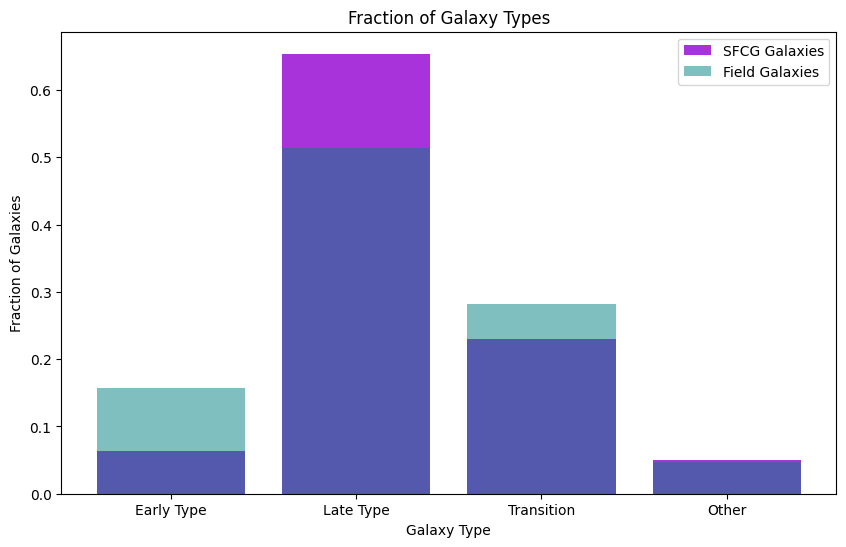

In [13]:
#sns.set_theme(style='whitegrid')

tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other']

tablas_sfcg = [early_type_sfcg, late_type_sfcg, transition_sfcg, other_sfcg]
tablas_cs = [early_type_cs, late_type_cs, transition_cs, other_cs]

# Crear una lista para almacenar las fracciones para cada tabla
fractions = []
amount = []
for tabla in tablas_sfcg:
    sf_galaxies = len(tabla)
    amount.append([sf_galaxies])
    # Calcular la fracción respecto al total
    sf_fraction = sf_galaxies / 474
    
    # Añadir las fracciones a la lista
    fractions.append([sf_fraction])

fractions_cs = []
amount_cs = [] 
for tabla_cs in tablas_cs:
    field_galaxies = len(tabla_cs)
    amount_cs.append([field_galaxies])
    field_fraction = field_galaxies / len(cs_no_zero)
    
    # Añadir las fracciones a la lista
    fractions_cs.append([field_fraction])

# Convertir los resultados en un array de numpy
fractions = np.array(fractions)
fractions_cs = np.array(fractions_cs)
amount = np.array(amount)
amount_cs = np.array(amount_cs)
print(fractions*100, fractions_cs*100)
print(amount, amount_cs)
# Crear el histograma apilado
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las posiciones de los bins (uno para cada tabla)
bins = np.arange(len(tabla_names))

bar1 = ax.bar(bins, fractions[:, 0], alpha = 0.8, label='SFCG Galaxies', color='darkviolet')
bar2 = ax.bar(bins, fractions_cs[:, 0], alpha = 0.5, label='Field Galaxies', color='teal')

ax.set_xticks(bins)
ax.set_xticklabels(tabla_names)
ax.set_xlabel('Galaxy Type')
ax.set_ylabel('Fraction of Galaxies')
ax.set_title('Fraction of Galaxy Types')
ax.legend()

plt.show()

In [23]:
transition_sfcg
higher_sersic_trans = (len(transition_sfcg[transition_sfcg['n_r'] > 1.5])/len(transition_sfcg))*100
higher_sersic_late = (len(late_type_sfcg[late_type_sfcg['n_r'] > 1.5])/len(late_type_sfcg))*100

higher_sersic_trans_cs = (len(transition_cs[transition_cs['n_r'] > 1.5])/len(transition_cs))*100
higher_sersic_late_cs = (len(late_type_cs[late_type_cs['n_r'] > 1.5])/len(late_type_cs))*100

print(f"El porcentaje de galaxias en transición con n > 1.5 en SFCG es: {round(higher_sersic_trans, 2)}%")
print(f"El porcentaje de galaxias late-type con n > 1.5 en SFCG es: {round(higher_sersic_late, 2)}%")
print(f"El porcentaje de galaxias en transición con n > 1.5 en el campo es: {round(higher_sersic_trans_cs, 2)}%")
print(f"El porcentaje de galaxias late-type con n > 1.5 en el campo es: {round(higher_sersic_late_cs, 2)}%")

El porcentaje de galaxias en transición con n > 1.75 en SFCG es: 19.27%
El porcentaje de galaxias late-type con n > 1.75 en SFCG es: 14.19%
El porcentaje de galaxias en transición con n > 1.75 en el campo es: 23.55%
El porcentaje de galaxias late-type con n > 1.75 en el campo es: 11.9%


In [14]:
sfr_decals = Table.read('sfr_decals_k_corrected.csv', format='ascii')
#sfr_decals.rename_column('logSFR_NUV', 'log_SFR')
#sfr_decals.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_decals.rename_column('stellar_mass', 'stellar_mass_phot')
sfr_decals.rename_column('zmemb', 'z')
sfr_decals = sfr_decals[sfr_decals['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_decals
sfr_decals['Distance (Mpc)'] = (sfr_decals['z']*c)/H_0
sfr_decals['M_i'] = sfr_decals['m_i_corrected'] - 5*np.log10(sfr_decals['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_decals['ebv']
sfr_decals['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_decals['m_g_corrected'] - sfr_decals['m_i_corrected']) - 0.4*sfr_decals['M_i'])


type_column = Column(['SFCG Galaxy'] * len(sfr_decals), name='Nature')
sfr_decals.add_column(type_column)
mask = ~np.isnan(sfr_decals['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_decals = sfr_decals[mask]
groups = sfr_decals.group_by('Group')
keys = groups.groups.keys
print(len(sfr_decals), len(keys))

378 110


In [15]:
sfr_cs = Table.read('sfr_cs_k_corrected.csv', format='ascii')
#sfr_cs.rename_column('logSFR_NUV', 'log_SFR')
#sfr_cs.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_cs.rename_column('stellar_mass', 'stellar_mass_phot')
sfr_cs.rename_column('zmemb', 'z')
sfr_cs = sfr_cs[sfr_cs['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_cs
sfr_cs['Distance (Mpc)'] = (sfr_cs['z']*c)/H_0
sfr_cs['M_i'] = sfr_cs['m_i_corrected'] - 5*np.log10(sfr_cs['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_cs['ebv']
sfr_cs['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_cs['m_g_corrected'] - sfr_cs['m_i_corrected']) - 0.4*sfr_cs['M_i'])


type_column = Column(['Field Galaxy'] * len(sfr_cs), name='Nature')
sfr_cs.add_column(type_column)
mask = ~np.isnan(sfr_cs['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_cs = sfr_cs[mask]

9.809295933964957 6.095017466960324 12.667545778768016


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


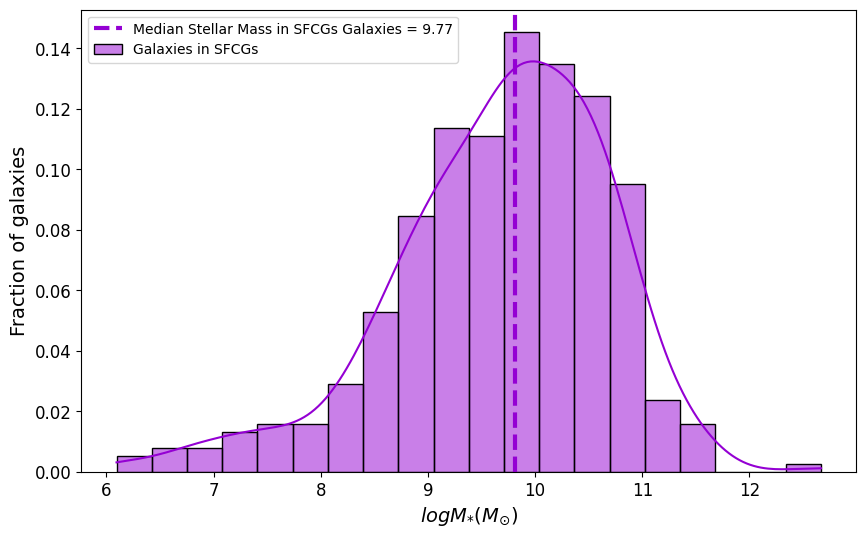

In [16]:
mass = sfr_decals['stellar_mass_phot_i']
# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass, kde=True, stat='probability', alpha=0.5, bins=20, color='darkviolet', label='Galaxies in SFCGs')

# Calcular medianas
median_x = np.median(mass)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median Stellar Mass in SFCGs Galaxies = 9.77')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, min(mass), max(mass))
plt.show()

In [17]:
type_column_cs = Column(['Field Galaxy'] * len(control_sample), name='Nature')
control_sample.add_column(type_column_cs)
control_sample['Distance (Mpc)'] = (control_sample['z']*c)/H_0
control_sample['M_i'] = control_sample['m_i_corrected'] - 5*np.log10(control_sample['Distance (Mpc)']*1000000) + 5 + 1.592*control_sample['ebv']
control_sample['stellar_mass_phot_i'] = (1.15 + 0.7*(control_sample['m_g_corrected'] - control_sample['m_i_corrected']) - 0.4*control_sample['M_i'])
control_sample

<Table length=1144>
Group  Gal    ID  ...   Distance (Mpc)           M_i         stellar_mass_phot_i
int64 int64 int64 ...      float64             float64             float64      
----- ----- ----- ... ------------------ ------------------- -------------------
    2     2  4345 ...  44.95548961424332  -16.24448992640121   8.103541915273635
    3     3   446 ...  64.98516320474776  -16.49919142284118   8.166002246494834
    5     5  3209 ...  81.00890207715133 -16.861554266436432   7.906011723514794
    7     7  6365 ...  50.74183976261127  -16.28820019080969   8.063646428347706
    8     8  6935 ...  66.76557863501483  -16.25838392219341   7.956331129250137
    9     9  8558 ...  85.45994065281897 -16.730165724497585   7.864133769951749
   10    10  1131 ...  50.29673590504451   -17.1820390944612    8.27396440201963
   11    11 14769 ...  77.00296735905044 -16.930030786537735   8.142782683232417
   13    13  1363 ...  83.23442136498515 -17.430119851559482   8.588686997490502
  ...   ...   ... ...                ...                 ...                 ...
 1273  1273  3036 ...  68.54599406528189 -11.655529632324305   5.290465135104122
 1274  1274  4933 ...  76.55786350148367 -20.004921043794365    9.77725773986059
 1275  1275  4811 ... 115.72700296735904 -17.920165984679656    8.61297969820901
 1276  1276  3743 ... 58.308605341246285  -16.81076356778172   8.068011088168394
 1277  1277   689 ...  293.3234421364985  -20.56897528314649  10.149173916503068
 1278  1278  4935 ...   408.160237388724 -20.848206742165647   10.14795081725927
 1280  1280  4972 ... 151.78041543026706 -20.186286965553695   9.891025430755363
 1282  1282  1928 ... 159.79228486646883   -18.5133430122671   8.993114540875979
 1283  1283  1812 ... 111.72106824925815  -20.20813304203411  10.095512916453298
 1284  1284 10549 ...  275.0741839762611 -20.351394292308875   9.963269356013782

In [18]:
sfr_decals_plots = sfr_decals['Group', 'Gal', 'z', 'ra', 'dec', 'logSFR_NUV', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'm_g_corrected', 'm_r_corrected', 'm_i_corrected', 'm_z_corrected', 'e_n_r', 'e_RE_r']
control_sample_plots = sfr_cs['Group', 'Gal', 'z', 'ra', 'dec', 'logSFR_NUV', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'm_g_corrected', 'm_r_corrected', 'm_i_corrected', 'm_z_corrected', 'e_n_r', 'e_RE_r']

cg_cs = vstack([sfr_decals_plots, control_sample_plots])

In [19]:
cg_cs = cg_cs[cg_cs['logSFR_NUV'] > -20]
cg_cs['log_sSFR'] = cg_cs['logSFR_NUV'] - cg_cs['stellar_mass_phot_i']
cg_cs['RE_g'] = cg_cs['RE_g']*0.262
cg_cs['RE_r'] = cg_cs['RE_r']*0.262
cg_cs['e_RE_r'] = cg_cs['e_RE_r']*0.262
cg_cs['RE_i'] = cg_cs['RE_i']*0.262
cg_cs['RE_z'] = cg_cs['RE_z']*0.262

cg_cs['Distance (Mpc)'] = 300000*cg_cs['z']/67.4
cg_cs['RE_g(kpc)'] = (cg_cs['RE_g']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_r(kpc)'] = (cg_cs['RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['e_RE_r(kpc)'] = (cg_cs['e_RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_i(kpc)'] = (cg_cs['RE_i']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_z(kpc)'] = (cg_cs['RE_z']*cg_cs['Distance (Mpc)'])/206.265

In [20]:
cg_cs = cg_cs[cg_cs['RE_g(kpc)'] < 100]
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'SFCG Galaxy']))
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'Field Galaxy']))

4.535448526538238
4.490815058068612


/home/seba/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [21]:
print(len(cg_cs), len(cg_cs[cg_cs['Nature'] == 'SFCG Galaxy']), len(cg_cs[cg_cs['Nature'] == 'Field Galaxy']))
cg_cs = cg_cs[(~np.isinf(cg_cs['stellar_mass_phot_i'])) & (~np.isnan(cg_cs['stellar_mass_phot_i'])) & (cg_cs['n_g'] != 0.0) & (~np.isinf(cg_cs['log_sSFR']))]
print(len(cg_cs), len(cg_cs[cg_cs['Nature'] == 'SFCG Galaxy']), len(cg_cs[cg_cs['Nature'] == 'Field Galaxy']))

1328 373 955
1304 373 931


In [22]:
print(cg_cs[(cg_cs['stellar_mass_phot_i'] == np.inf) & (cg_cs['Nature'] == 'Field Galaxy')])

Group Gal  z   ra dec ... RE_g(kpc) RE_r(kpc) e_RE_r(kpc) RE_i(kpc) RE_z(kpc)
----- --- --- --- --- ... --------- --------- ----------- --------- ---------


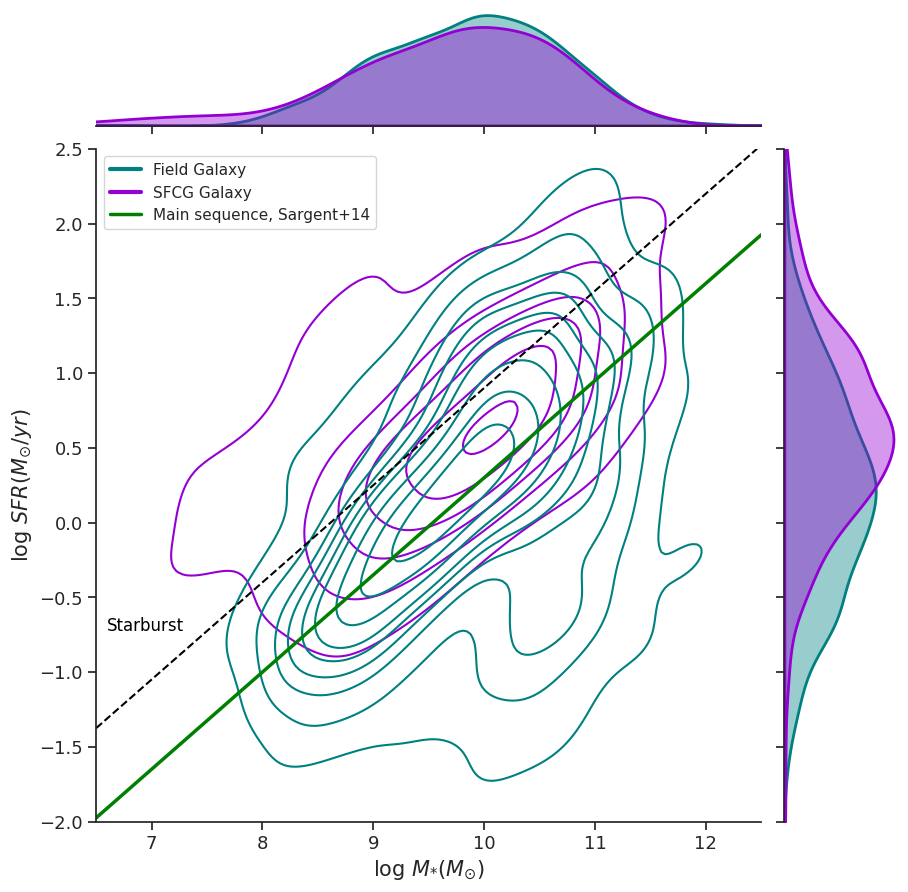

In [23]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Ignorar los warnings
warnings.filterwarnings("ignore")

# Definir paleta personalizada
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

sns.set_theme(style="ticks")

# Definir variables
y = cg_cs['logSFR_NUV']
x = cg_cs['stellar_mass_phot_i']
sur = cg_cs['Nature']

# Crear la figura
g = sns.JointGrid(data=cg_cs, x=x, y=y, hue=sur, palette=custom_palette, height=9)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)

# Añadir la recta discontinua
g.ax_joint.axline((9, 0.25), slope=0.65, color='black', linestyle='--')

# Añadir la línea verde con el label
line_green = g.ax_joint.axline((9, -0.35), slope=0.65, color='green', linestyle='-', linewidth=2.5)
line_green.set_label('Main sequence, Sargent+14')  # Asignar el label manualmente

# Limitar los ejes
g.ax_joint.set_xlim(6.5, 12.5)
g.ax_joint.set_ylim(-2, 2.5)

# Añadir texto al gráfico
g.ax_joint.text(6.6, -0.75, 'Starburst', color='black', fontsize=12, verticalalignment='bottom')

# Configurar etiquetas de ejes y ticks
g.set_axis_labels("log $M_{*} (M_{\odot})$", "log $SFR (M_{\odot}/yr)$", fontsize=15)
g.ax_joint.tick_params(axis='both', labelsize=13)

# Crear handles y labels para la leyenda
handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
]
handles.append(Line2D([0], [0], color='green', linestyle='-', linewidth=2.5))  # Línea verde
labels = list(custom_palette.keys()) + ['Main sequence, Sargent+14']

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

# Mostrar el gráfico
plt.show()

In [33]:
# Definir ecuaciones de las líneas
def eq_starburst_line(mass):  # Línea punteada
    return 0.65 * (mass - 9) + 0.25

def eq_main_line(mass):  # Línea verde
    return 0.65 * (mass - 9) - 0.35

# Filtrar por tipo de galaxia
sfcg_mask = cg_cs['Nature'] == 'SFCG Galaxy'
field_mask = cg_cs['Nature'] == 'Field Galaxy'

# Contar galaxias en cada categoría
total_sfcg = sfcg_mask.sum()
total_field = field_mask.sum()

# Contar galaxias por encima de cada línea
above_starburst_sfcg = (cg_cs['logSFR_NUV'][sfcg_mask] > eq_starburst_line(cg_cs['stellar_mass_phot_i'][sfcg_mask])).sum() / total_sfcg
above_main_sfcg = (cg_cs['logSFR_NUV'][sfcg_mask] > eq_main_line(cg_cs['stellar_mass_phot_i'][sfcg_mask])).sum() / total_sfcg

above_starburst_cs = (cg_cs['logSFR_NUV'][field_mask] > eq_starburst_line(cg_cs['stellar_mass_phot_i'][field_mask])).sum() / total_field
above_main_cs = (cg_cs['logSFR_NUV'][field_mask] > eq_main_line(cg_cs['stellar_mass_phot_i'][field_mask])).sum() / total_field

# Resultados
print(f"Galaxias sobre la línea starburst en SFCGs: {above_starburst_sfcg * 100:.2f}%")
print(f"Galaxias sobre la línea main en SFCGs: {above_main_sfcg * 100:.2f}%")

print(f"Galaxias sobre la línea starburst en CS: {above_starburst_cs * 100:.2f}%")
print(f"Galaxias sobre la línea main en CS: {above_main_cs * 100:.2f}%")


Galaxias sobre la línea starburst en SFCGs: 38.34%
Galaxias sobre la línea main en SFCGs: 84.72%
Galaxias sobre la línea starburst en CS: 12.67%
Galaxias sobre la línea main en CS: 52.74%


In [40]:
import numpy as np

# Definir la dispersión sigma (ajustar según referencia o datos)
sigma = 0.2  # Supongamos 0.3 dex, ajustar según paper

# Determinar los límites de ±2σ alrededor de la línea main sequence
def eq_main_line(mass):
    return 0.65 * (mass - 9) - 0.35

lower_bound = eq_main_line(cg_cs['stellar_mass_phot_i']) - 2 * sigma
upper_bound = eq_main_line(cg_cs['stellar_mass_phot_i']) + 2 * sigma

# Filtrar galaxias Field dentro de 2σ
within_2sigma_field = ((cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'Field Galaxy'] <= lower_bound[cg_cs['Nature'] == 'Field Galaxy']) &
                        (cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'Field Galaxy'] <= upper_bound[cg_cs['Nature'] == 'Field Galaxy'])).sum()

# Filtrar galaxias Field dentro de 2σ
within_2sigma_sfcg = ((cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'SFCG Galaxy'] >= lower_bound[cg_cs['Nature'] == 'SFCG Galaxy']) &
                        (cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'SFCG Galaxy'] <= upper_bound[cg_cs['Nature'] == 'SFCG Galaxy'])).sum()

# Calcular porcentaje
total_field = (cg_cs['Nature'] == 'Field Galaxy').sum()
percentage_within_2sigma = (within_2sigma_field / total_field) * 100

# Calcular porcentaje
total_sfcg = (cg_cs['Nature'] == 'SFCG Galaxy').sum()
percentage_within_2sigma_sfcg = (within_2sigma_sfcg / total_sfcg) * 100

# Mostrar resultado
print(f"Porcentaje de galaxias Field dentro de ±2σ de la Main Sequence: {percentage_within_2sigma:.2f}%")
print(f"Porcentaje de galaxias SFCG dentro de ±2σ de la Main Sequence: {percentage_within_2sigma_sfcg:.2f}%")



Porcentaje de galaxias Field dentro de ±2σ de la Main Sequence: 19.76%
Porcentaje de galaxias SFCG dentro de ±2σ de la Main Sequence: 43.70%


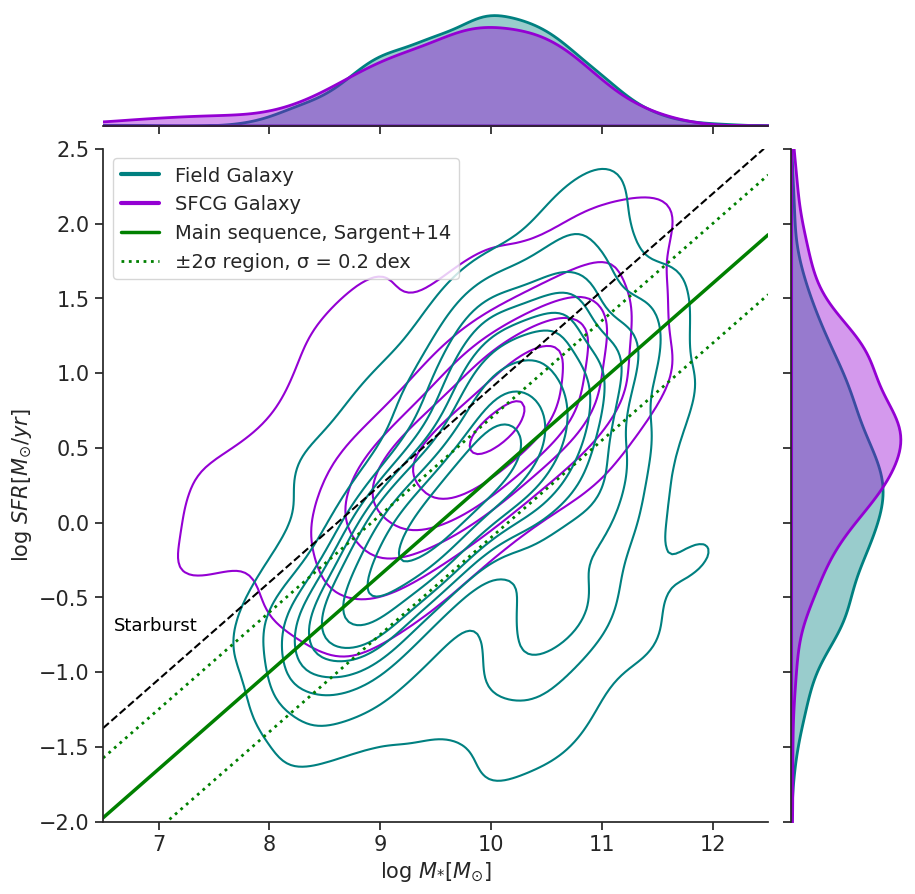

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Definir la dispersión sigma
sigma = 0.2  # Ajustar si tienes una referencia específica

# Función para la ecuación de la línea de la secuencia principal
def eq_main_line(mass):
    return 0.65 * (mass - 9) - 0.35

# Definir variables
y = cg_cs['logSFR_NUV']
x = cg_cs['stellar_mass_phot_i']
sur = cg_cs['Nature']

# Crear la figura
g = sns.JointGrid(data=cg_cs, x=x, y=y, hue=sur, palette=custom_palette, height=9)

# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(sns.kdeplot, fill=False, alpha=1, linewidth=0)

# Gráficos marginales: KDE relleno
g.plot_marginals(sns.kdeplot, fill=True, common_norm=False, alpha=0.4, linewidth=2)

# Añadir la recta discontinua de Starburst
g.ax_joint.axline((9, 0.25), slope=0.65, color='black', linestyle='--')

# Añadir la línea principal (secuencia principal)
line_green = g.ax_joint.axline((9, -0.35), slope=0.65, color='green', linestyle='-', linewidth=2.5)
line_green.set_label('Main sequence, Sargent+14')

# Generar valores de masa estelar para las líneas de 2σ
mass_range = np.linspace(6.5, 12.5, 100)
main_line_values = eq_main_line(mass_range)
upper_bound = main_line_values + 2 * sigma
lower_bound = main_line_values - 2 * sigma

# Graficar las líneas de ±2σ
g.ax_joint.plot(mass_range, upper_bound, color='green', linestyle='dotted', linewidth=2)
g.ax_joint.plot(mass_range, lower_bound, color='green', linestyle='dotted', linewidth=2)

# Limitar los ejes
g.ax_joint.set_xlim(6.5, 12.5)
g.ax_joint.set_ylim(-2, 2.5)

# Añadir texto descriptivo
g.ax_joint.text(6.6, -0.75, 'Starburst', color='black', fontsize=13, verticalalignment='bottom')

# Configurar etiquetas de ejes y ticks
g.set_axis_labels("log $M_{*} [M_{\odot}]$", "log $SFR [M_{\odot}/yr]$", fontsize=15)
g.ax_joint.tick_params(axis='both', labelsize=15)

# Crear handles y labels para la leyenda
handles = [
    Line2D([0], [0], color='teal', lw=3, label='Field Galaxy'),
    Line2D([0], [0], color='darkviolet', lw=3, label='SFCG Galaxy'),
    Line2D([0], [0], color='green', linestyle='-', linewidth=2.5, label='Main sequence, Sargent+14'),
    Line2D([0], [0], color='green', linestyle='dotted', linewidth=2, label='±2σ region, σ = 0.2 dex')
]

# Añadir la leyenda
g.ax_joint.legend(handles=handles, loc="upper left", fontsize=14)

# Mostrar el gráfico
plt.show()


Nature
Field Galaxy    0.761595
SFCG Galaxy     0.839881
Name: log_sSFR, dtype: float64


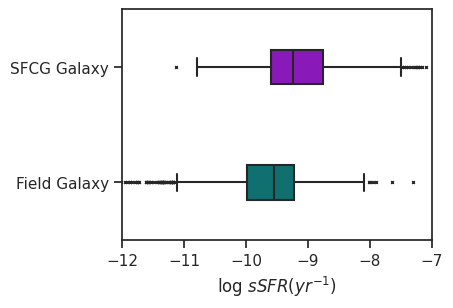

In [45]:
plt.figure(figsize=(4, 3))

# Convertir la tabla de Astropy a un DataFrame de Pandas
cg_cs_df = cg_cs.to_pandas()

# Variables para el gráfico
x = 'log_sSFR'
y = 'stellar_mass_phot_i'
sur = 'Nature'
# Definir paleta personalizada
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}
# Crear la figura
g=sns.boxplot(data=cg_cs_df, x=x, y=sur, palette=custom_palette, fliersize=2, flierprops={"marker": "x"}, width=.3)
# Añadir líneas de la mediana 
#plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=1, label=f'Median sSFR in SFCGs')
#plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=1, label=f'Median sSFR in the Field')
g.set_xlim(-12, -7)
g.set_xlabel('log $sSFR(yr^{-1})$')
g.set_ylabel('')

# Calcular el IQR para cada categoría en 'Nature'
iqr_values = cg_cs_df.groupby('Nature')['log_sSFR'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

# Mostrar los resultados
print(iqr_values)

# Mostrar el gráfico
plt.show()


-9.239687291238782 -9.55285499338337 0.3131677021445878
0.2554461604029223 8.993589089097211e-16


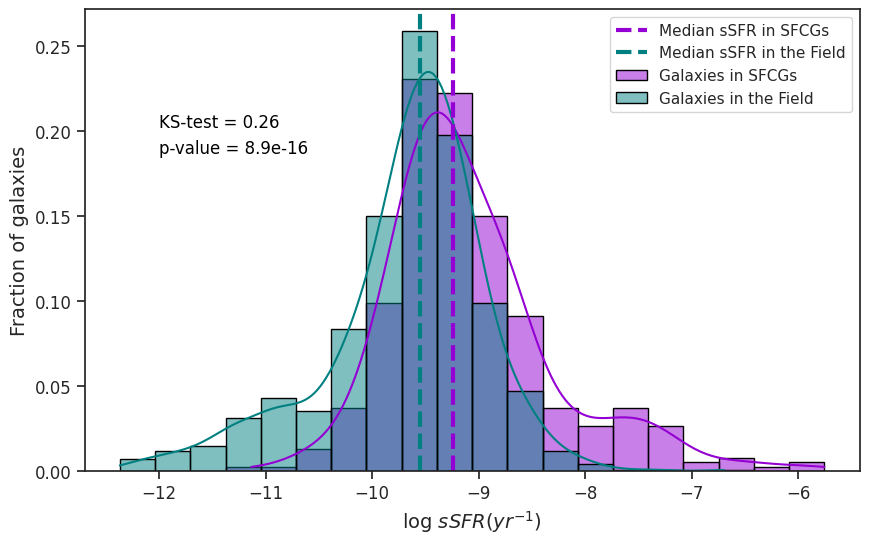

In [46]:
ssfr_sfcg = cg_cs['log_sSFR'][cg_cs['Nature'] == 'SFCG Galaxy']
ssfr_cs = cg_cs['log_sSFR'][cg_cs['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(ssfr_sfcg.min(), ssfr_cs.min()), 
                        max(ssfr_sfcg.max(), ssfr_cs.max()), 
                        21)# Crear los histogramas con los mismos bordes de bins

plt.figure(figsize=(10, 6))
sns.histplot(ssfr_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in SFCGs', edgecolor='black')
sns.histplot(ssfr_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the Field', edgecolor='black')

# Calcular medianas
median_x = np.median(ssfr_sfcg)
median_x_2 = np.median(ssfr_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median sSFR in SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label=f'Median sSFR in the Field')

# Etiquetas y título
plt.xlabel('log $sSFR (yr^{-1})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, median_x_2, abs(median_x-median_x_2))
# Añadir texto al gráfico
plt.text(-12, 0.20, 'KS-test = 0.26', color='black', fontsize=12, verticalalignment='bottom')
plt.text(-12, 0.185, 'p-value = 8.9e-16', color='black', fontsize=12, verticalalignment='bottom')
# Realizar el KS test
ks_stat, p_value = ks_2samp(ssfr_sfcg, ssfr_cs)
print(ks_stat, p_value)
plt.show()

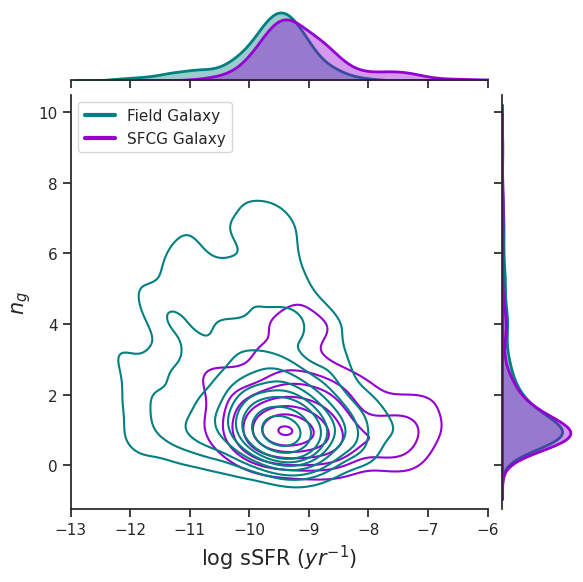

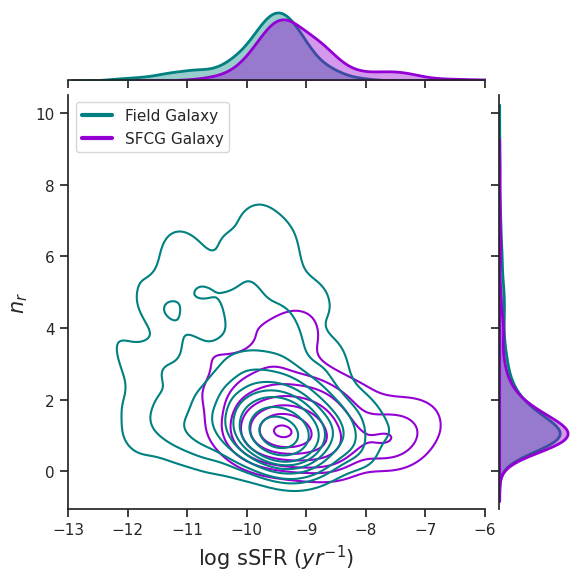

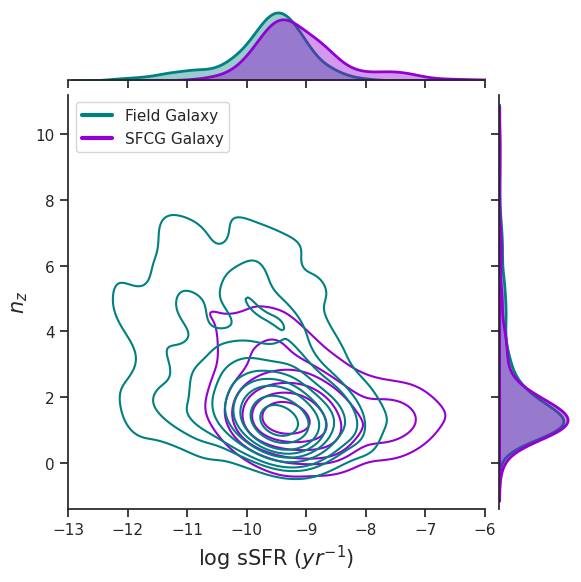

In [26]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']
filtro = ['g', 'r', 'z']
# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col, filtro in zip(y_columns, filtro):
    # Crear la figura
    g = sns.JointGrid(data=cg_cs, x=x, y=cg_cs[col], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    
    # Añadir títulos
    g.set_axis_labels("log sSFR $(yr^{-1})$", f"$n_{filtro}$", fontsize=15)
#    g.fig.suptitle(f"sSFR vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga
    # Limitar los ejes
    g.ax_joint.set_xlim(-13, -6)
    #g.ax_joint.set_ylim(-2, 2.5)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")
    # Mostrar el gráfico
    plt.show()


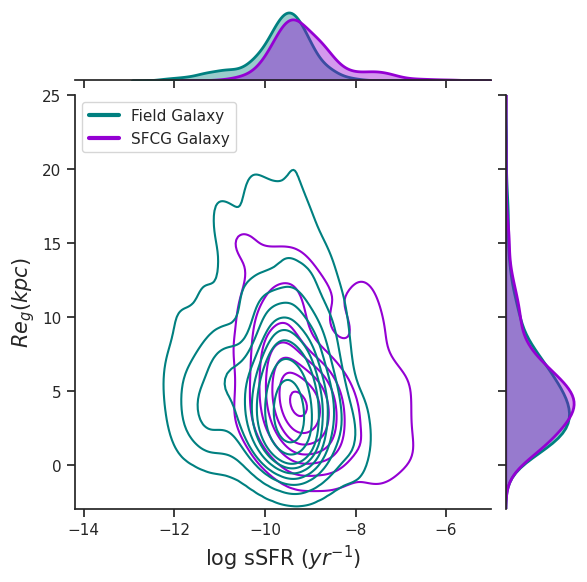

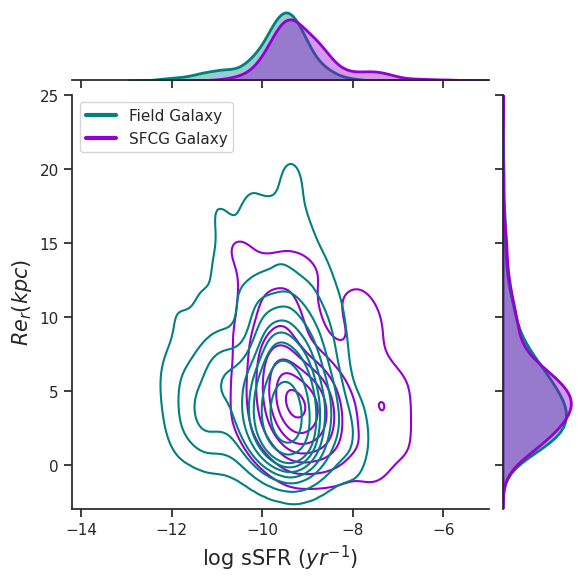

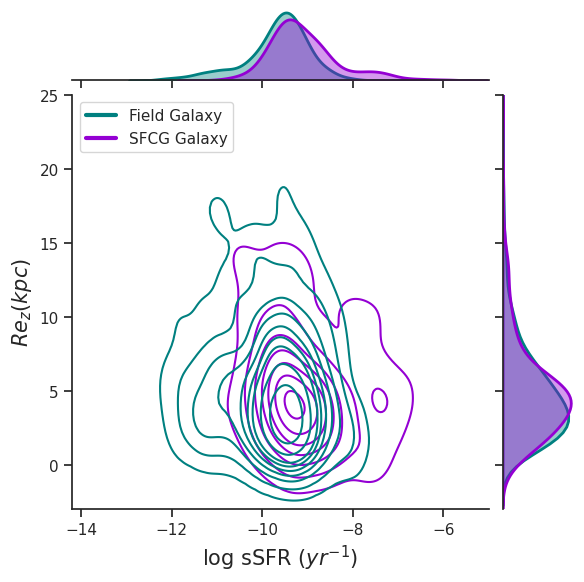

In [25]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col, f in zip(y_columns, filtro):
    # Crear la figura
    g = sns.JointGrid(data=cg_cs, x=x, y=cg_cs[col], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-14.2, -5)
    g.ax_joint.set_ylim(-3, 25)
    # Añadir títulos
    g.set_axis_labels("log sSFR $(yr^{-1})$", f"$Re_{f} (kpc)$", fontsize=15)
    #g.fig.suptitle(f"sSFR vs Effective Radius", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")
    # Mostrar el gráfico
    plt.show()

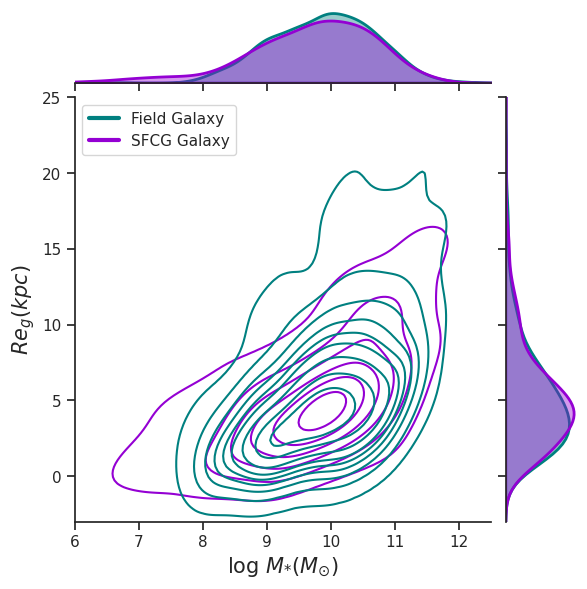

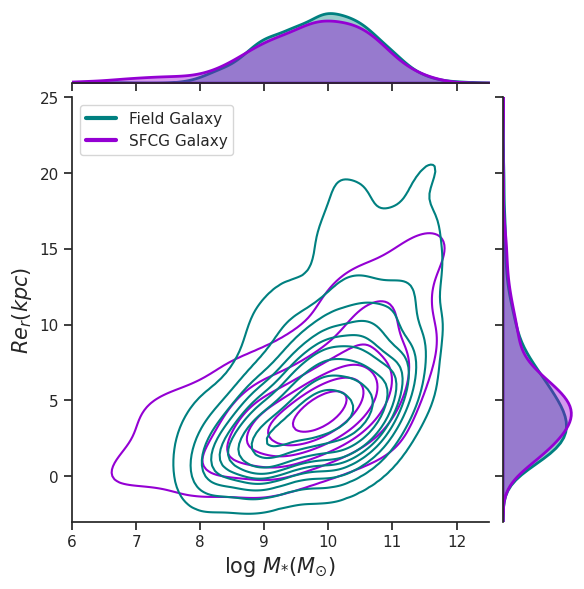

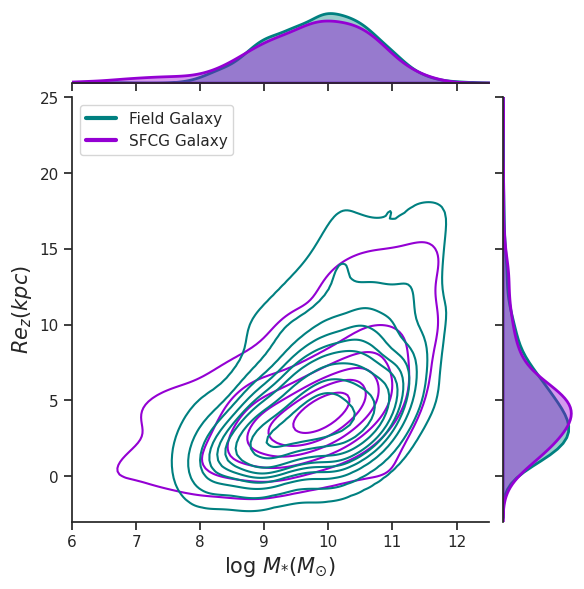

In [26]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['stellar_mass_phot_i'][cg_cs['stellar_mass_phot_i']!=0]
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']
# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col, f in zip(y_columns, filtro):
    # Crear la figura
    g = sns.JointGrid(data=cg_cs, x=x, y=cg_cs[col], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(6, 12.5)
    g.ax_joint.set_ylim(-3, 25)
    # Añadir títulos
    g.set_axis_labels("log $M_{*} (M_{\odot})$", f"$Re_{f} (kpc)$", fontsize=15)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")
    # Mostrar el gráfico
    plt.show()

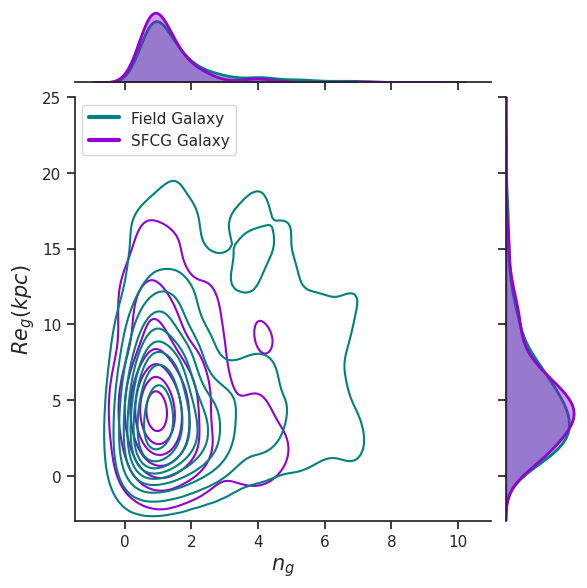

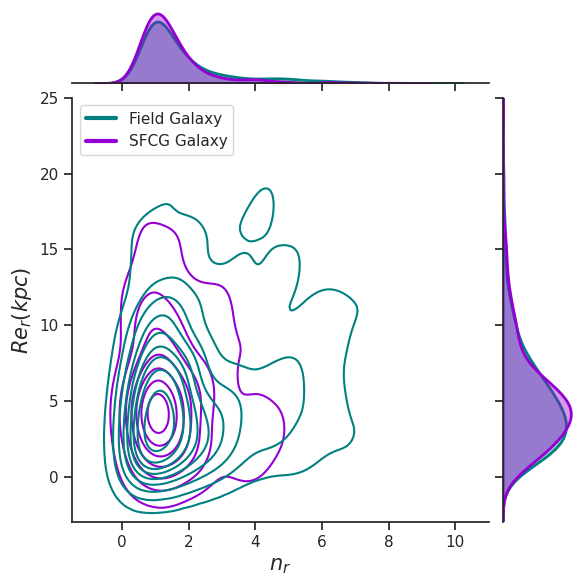

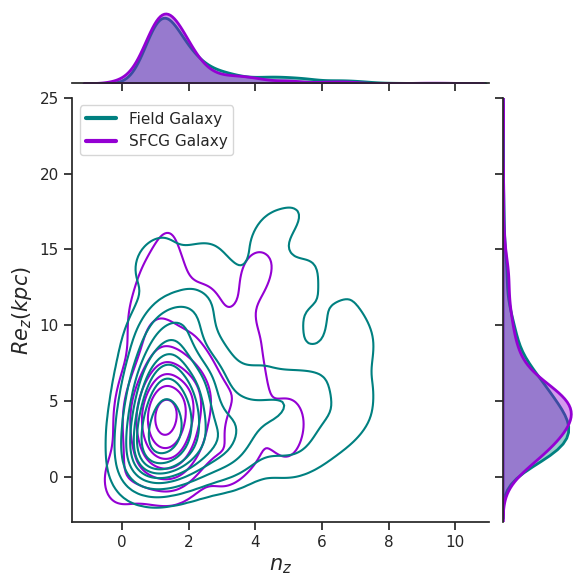

In [27]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']
# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col_x, col_y, f in zip(x_columns, y_columns, filtro):
    # Crear la figura
    g = sns.JointGrid(data=cg_cs, x=cg_cs[col_x], y=cg_cs[col_y], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-1.5, 11)
    g.ax_joint.set_ylim(-3, 25)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")
    # Añadir títulos
    g.set_axis_labels(f"$n_{f}$", f"$Re_{f} (kpc)$", fontsize=15)

    # Mostrar el gráfico
    plt.show()

## Separar las galaxias por región en el plot de g-r vs n

In [47]:
late_type = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) < 0.67) & (cg_cs['n_r'] <= 2.5)]
transition = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) > 0.67) & (cg_cs['n_r'] <= 2.5)]
early_type = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) > 0.67) & (cg_cs['n_r'] > 2.5)]
other = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) < 0.67) & (cg_cs['n_r'] > 2.5)]
print(len(late_type), len(transition), len(early_type), len(other))
transition = transition[(transition['n_r'] != 0.0) & (transition['RE_r(kpc)'] != 0.0)]

739 340 159 60


[[ 5.69105691 14.85468245]
 [65.31165312 53.60602799]
 [24.11924119 27.01829925]
 [ 4.87804878  4.52099031]]
[[ 21 138]
 [241 498]
 [ 89 251]
 [ 18  42]]


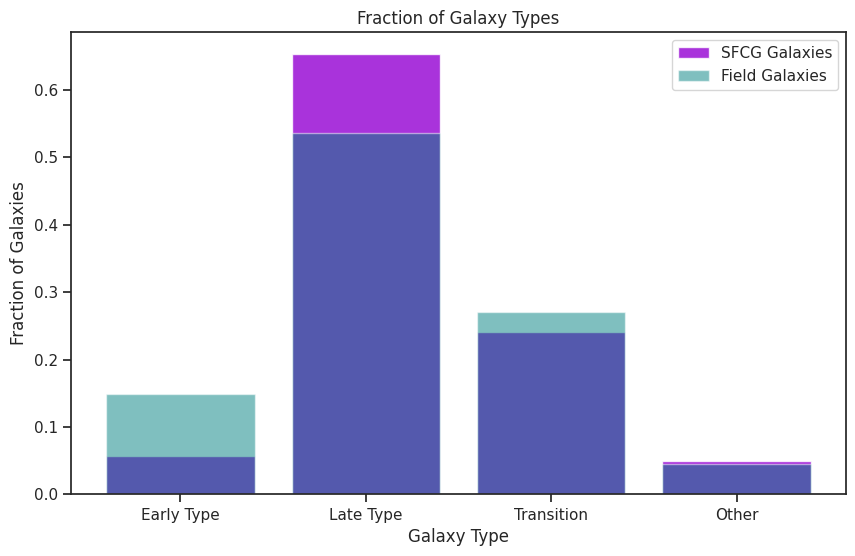

In [29]:
#sns.set_theme(style='whitegrid')

tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other']

tablas = [early_type, late_type, transition, other]

# Contar el total de galaxias por 'Nature' en todas las tablas
total_sfcg = 0
total_field = 0
for tabla in tablas:
    total_sfcg += np.sum(tabla['Nature'] == 'SFCG Galaxy')
    total_field += np.sum(tabla['Nature'] == 'Field Galaxy')

# Crear una lista para almacenar las fracciones para cada tabla
fractions = []
amount = []
for tabla in tablas:
    sf_galaxies = np.sum(tabla['Nature'] == 'SFCG Galaxy')
    field_galaxies = np.sum(tabla['Nature'] == 'Field Galaxy')
    amount.append([sf_galaxies, field_galaxies])
    # Calcular la fracción respecto al total
    sf_fraction = sf_galaxies / total_sfcg
    field_fraction = field_galaxies / total_field
    
    # Añadir las fracciones a la lista
    fractions.append([sf_fraction, field_fraction])

# Convertir los resultados en un array de numpy
fractions = np.array(fractions)
amount = np.array(amount)
print(fractions*100)
print(amount)
# Crear el histograma apilado
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las posiciones de los bins (uno para cada tabla)
bins = np.arange(len(tabla_names))

bar1 = ax.bar(bins, fractions[:, 0], alpha = 0.8, label='SFCG Galaxies', color='darkviolet')
bar2 = ax.bar(bins, fractions[:, 1], alpha = 0.5, label='Field Galaxies', color='teal')

ax.set_xticks(bins)
ax.set_xticklabels(tabla_names)
ax.set_xlabel('Galaxy Type')
ax.set_ylabel('Fraction of Galaxies')
ax.set_title('Fraction of Galaxy Types')
ax.legend()

plt.show()

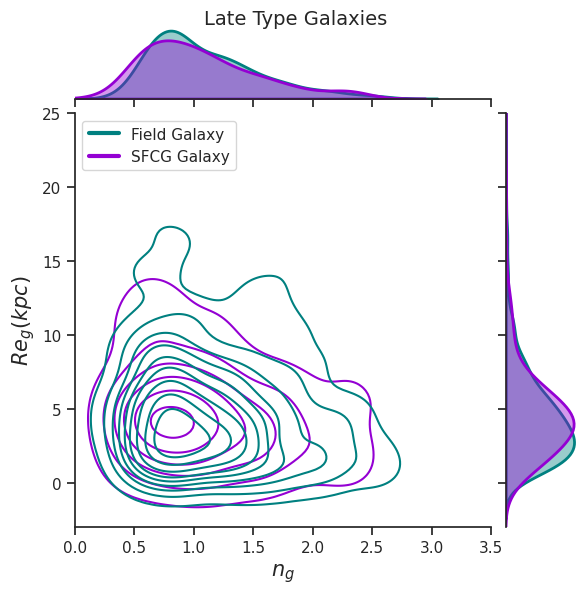

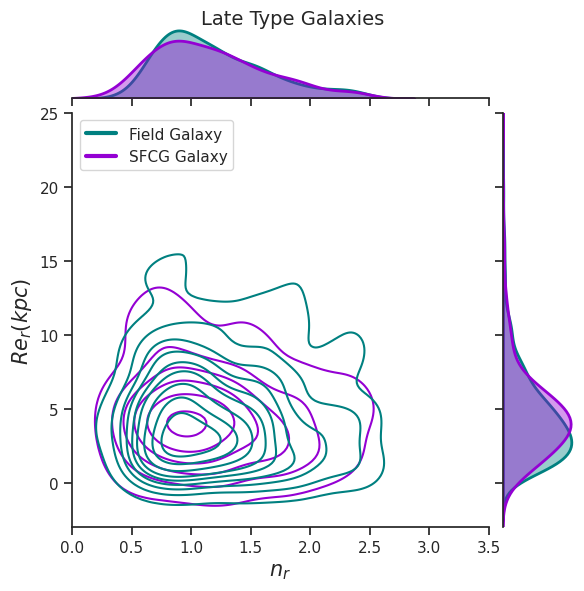

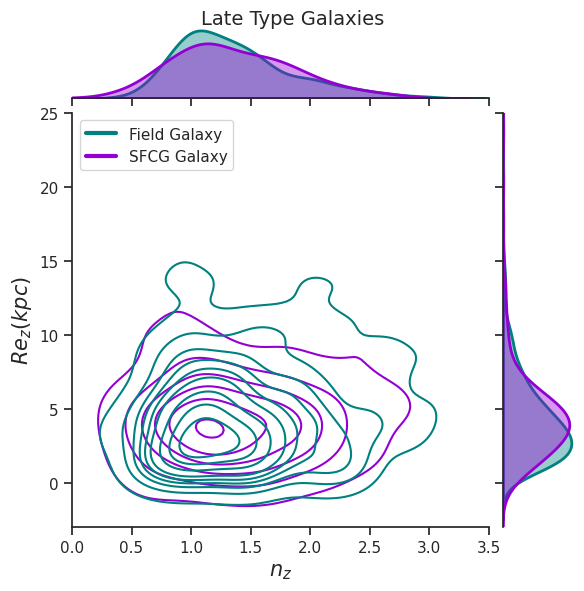

In [30]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']
# Crear el gráfico
for col_x, col_y, f in zip(x_columns, y_columns, filtro):    
    # Crear la figura
    g = sns.JointGrid(data=late_type, x=late_type[col_x], y=late_type[col_y], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 3.5)
    g.ax_joint.set_ylim(-3, 25)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")
    # Añadir títulos
    g.set_axis_labels(f"$n_{f}$", f"$Re_{f} (kpc)$", fontsize=15)
    g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga
    # Mostrar el gráfico
    plt.show()

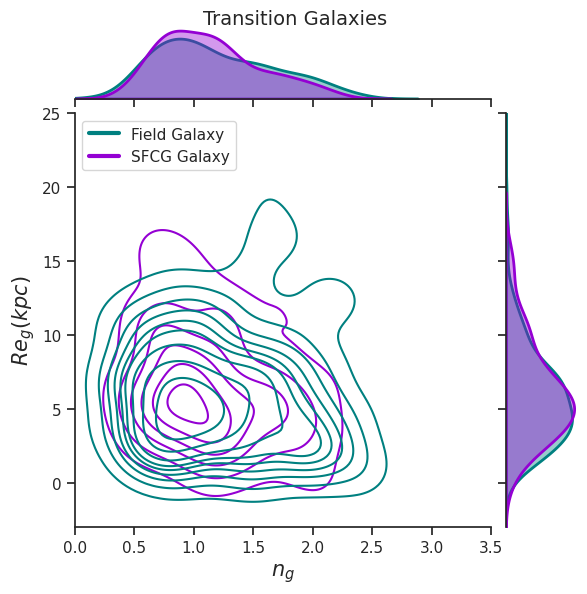

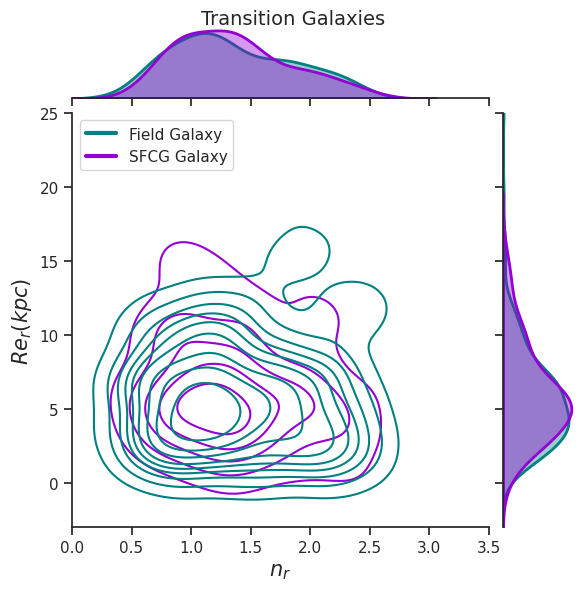

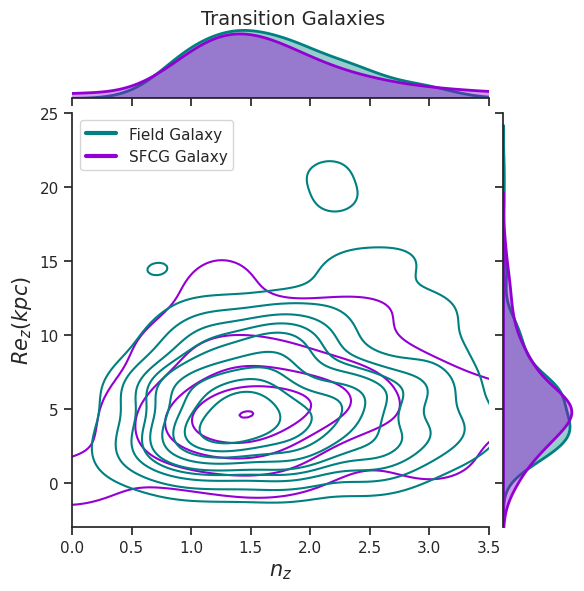

In [31]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']
# Crear el gráfico
for col_x, col_y, f in zip(x_columns, y_columns, filtro):    
    # Crear la figura
    g = sns.JointGrid(data=transition, x=transition[col_x], y=transition[col_y], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 3.5)
    g.ax_joint.set_ylim(-3, 25)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")
    # Añadir títulos
    g.set_axis_labels(f"$n_{f}$", f"$Re_{f} (kpc)$", fontsize=15)
    g.fig.suptitle(f"Transition Galaxies", fontsize=14)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga
    # Mostrar el gráfico
    plt.show()

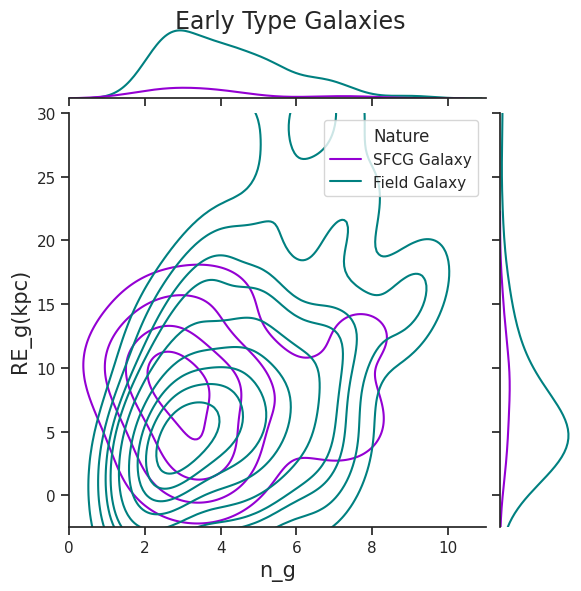

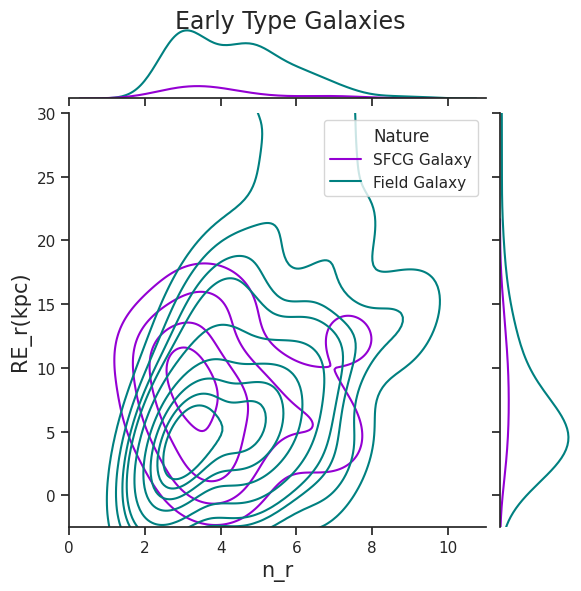

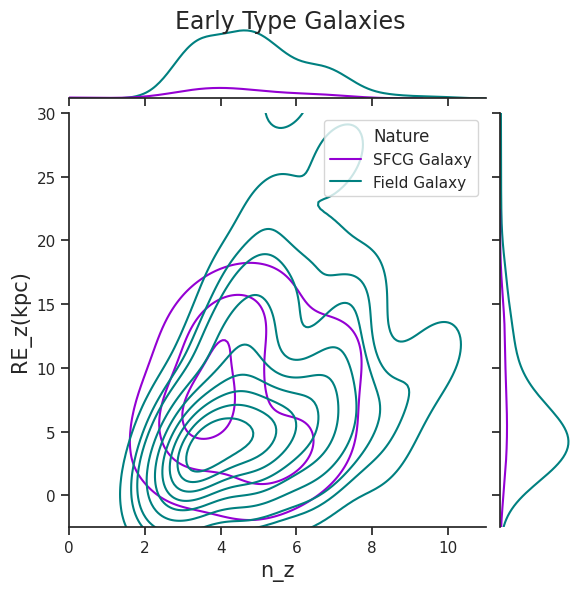

In [32]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = early_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=early_type,
        x=early_type[col_x], y=early_type[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 11)
    g.ax_joint.set_ylim(-2.5, 30)

    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Early Type Galaxies", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

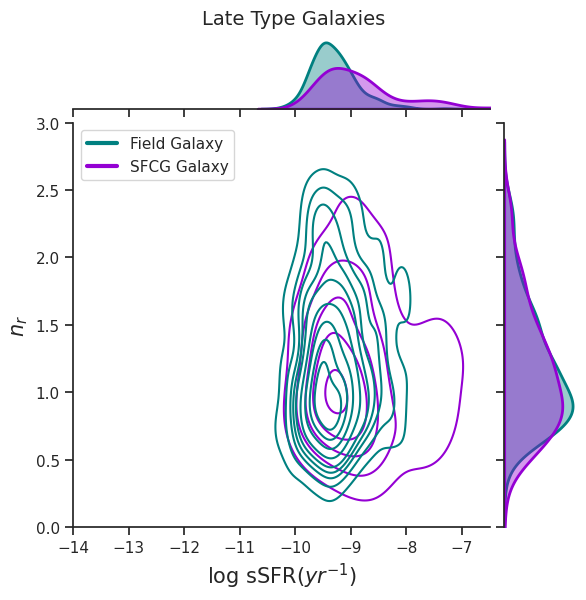

In [33]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x = late_type['log_sSFR']
y = late_type['n_r']
# Crear la figura
g = sns.JointGrid(data=late_type, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-14, -6.5)
g.ax_joint.set_ylim(0, 3)
# Añadir títulos
g.set_axis_labels("log sSFR($yr^{-1}$)", f"$n_r$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

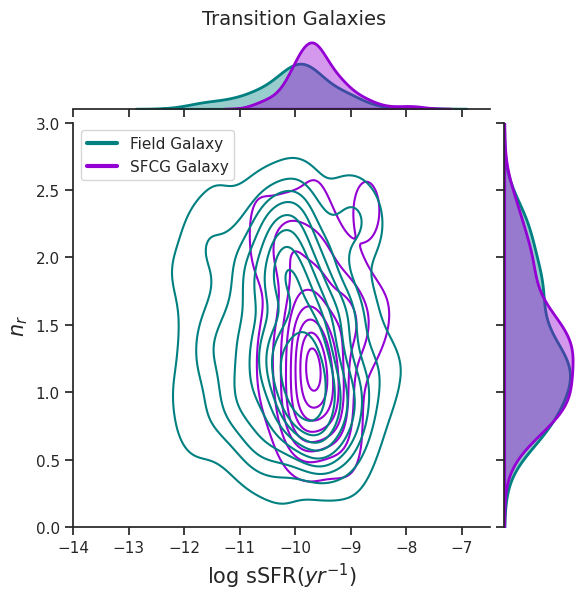

In [34]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x = transition['log_sSFR']
y = transition['n_r']
# Crear la figura
g = sns.JointGrid(data=transition, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-14, -6.5)
g.ax_joint.set_ylim(0, 3)
# Añadir títulos
g.set_axis_labels("log sSFR($yr^{-1}$)", f"$n_r$", fontsize=15)
g.fig.suptitle(f"Transition Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

# Mostrar el gráfico
plt.show()

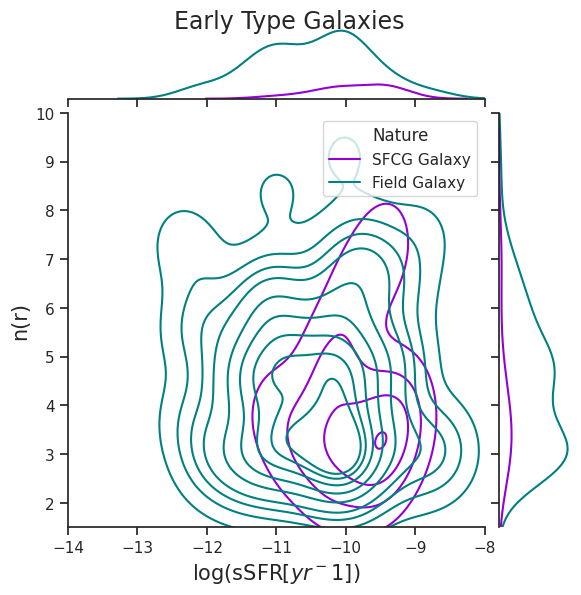

In [35]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = early_type['Nature']

# Lista de columnas que quieres graficar
x = early_type['log_sSFR']
y = early_type['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=early_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(1.5, 10)
# Añadir títulos
g.set_axis_labels(f"log(sSFR[$yr^{-1}$])", f"n(r)", fontsize=15)
g.fig.suptitle(f"Early Type Galaxies", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

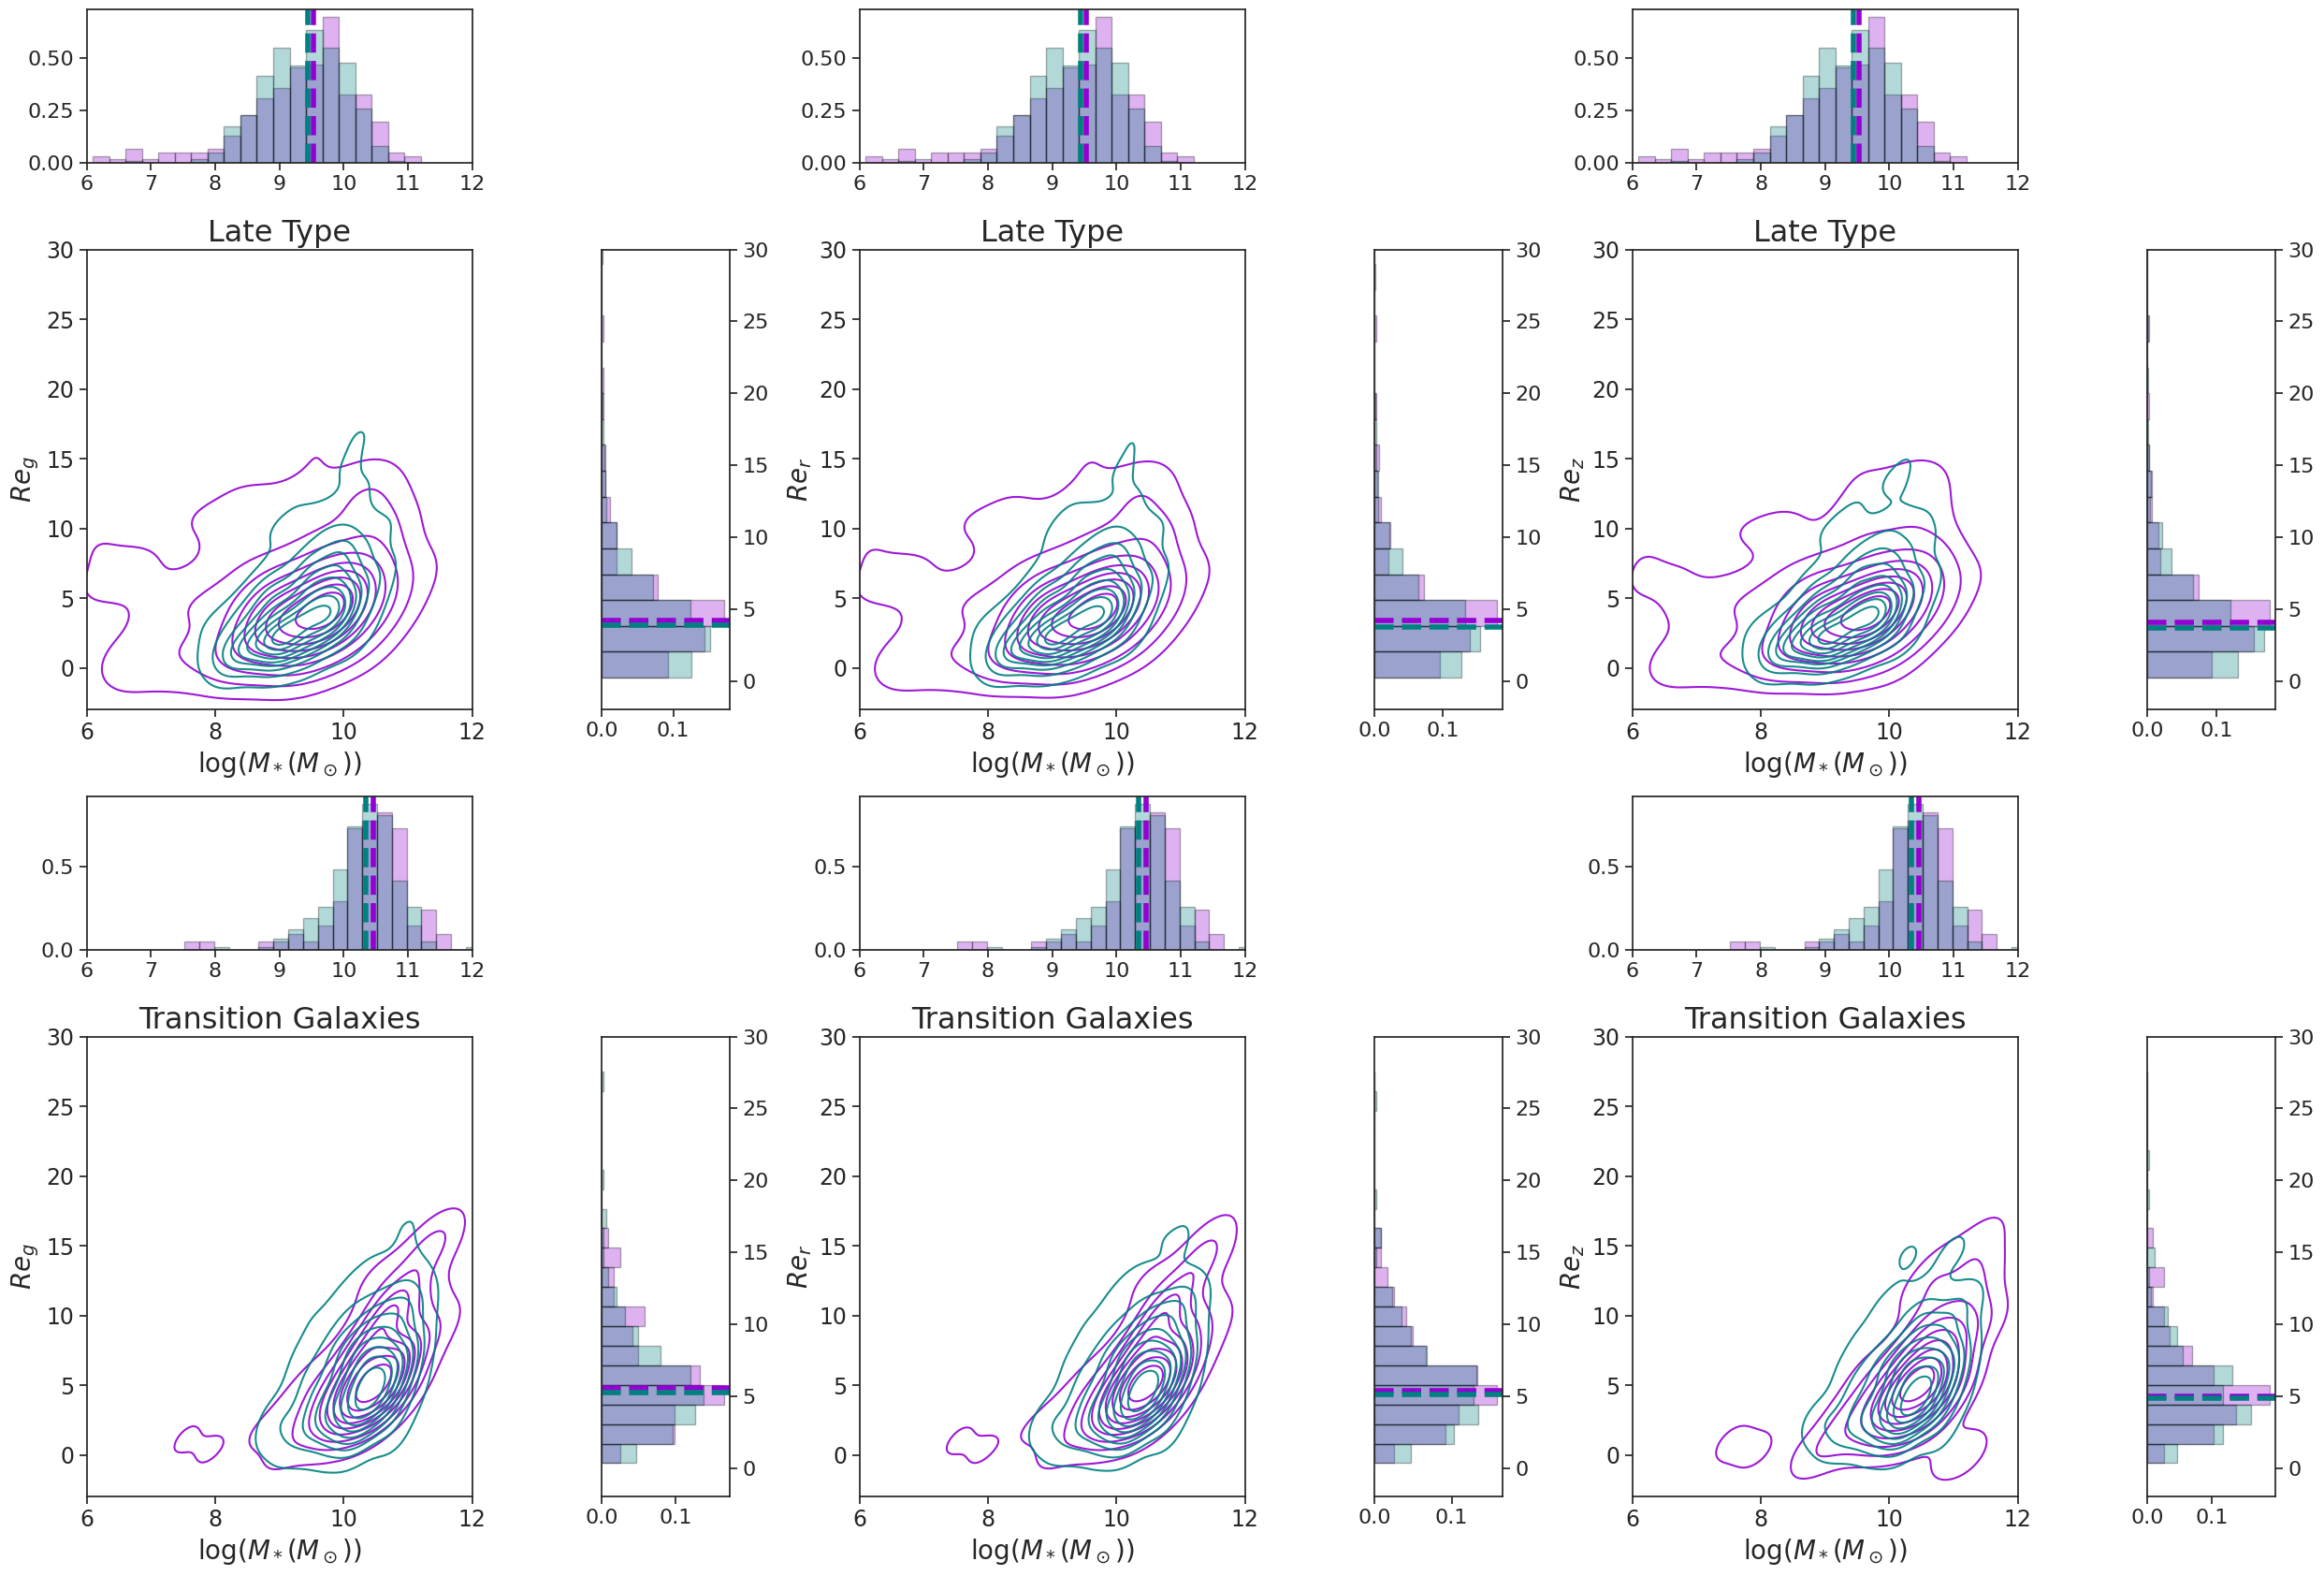

In [36]:
# Diccionario con los tipos de galaxias
galaxy_types = {'Transition Galaxies': transition, 'Late Type': late_type}

# Colores para los dos tipos de galaxias
color_map = {'SFCG Galaxy': 'darkviolet', 'Field Galaxy': 'teal'}
filtros = ['g', 'r', 'z']
# Figuras y ejes
fig, axs = plt.subplots(4, 6, figsize=(25, 17), gridspec_kw={'width_ratios': [6, 2, 6, 2, 6, 2], 'height_ratios': [2, 6, 2, 6]})

for i, (name, data) in enumerate(galaxy_types.items()):
    bin_edges = np.linspace(min(data['stellar_mass_phot_i'].min(), data['stellar_mass_phot_i'].min()), 
                        max(data['stellar_mass_phot_i'].max(), data['stellar_mass_phot_i'].max()), 
                        21)
    bin_edges_re = np.linspace(min(data['RE_g(kpc)'].min(), data['RE_g(kpc)'].min()), 
                        max(data['RE_g(kpc)'].max(), data['RE_g(kpc)'].max()), 
                        21)
    for j, re_col in enumerate(['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']):
        ax = axs[2*i-1, 2*j]
        ax_histx = axs[2*i-2, 2*j] #Panel del histograma en x
        ax_histy = axs[2*i-1, 2*j+1] #Panel del histograma en y
        

        ax.set_title(f'{name}', size=23)
        # Dividir los datos por Nature
        for nature_type, color in color_map.items():
            subset = data[data['Nature'] == nature_type]
            
            #Graficando KDE
            kde_plot = sns.kdeplot(x=subset['stellar_mass_phot_i'], y=subset[re_col], ax=ax, fill=False, color=color, alpha = 0.9, label=nature_type)
            
            # Calcular medianas
            median_x = np.median(subset['stellar_mass_phot_i'])
            median_y = np.median(subset[re_col])
            
            #Histogramas
            ax_histx.hist(subset['stellar_mass_phot_i'], bins=bin_edges, color=color, alpha=0.3, density=True, edgecolor='black')
            ax_histy.hist(subset[re_col], bins=bin_edges_re, color=color, alpha=0.3, orientation='horizontal', density=True, edgecolor='black')
        
            # Añadir líneas de la mediana
            ax_histx.axvline(median_x, color=color, linestyle='--', linewidth=4)
            ax_histy.axhline(median_y, color=color, linestyle='--', linewidth=4)
        
        # Personalización de ejes
        ax_histx.set_xlim(6, 12)
        ax_histy.set_ylim(-2, 30)
        ax_histx.tick_params(axis='x', labelsize=16)
        ax_histx.tick_params(axis='y', labelsize=16)
        ax_histy.tick_params(axis='x', labelsize=16)
        ax_histy.tick_params(axis='y', labelsize=16)
        
        ax_histy.yaxis.set_label_position("left")
        ax_histy.yaxis.tick_right()
        # Etiquetas personalizadas de los ejes
        ax.set_xlabel(f'log($M_*(M_\odot)$)', size=20)
        ax.set_ylabel(f'$Re_{filtros[j]}$', size=20)
        ax.set_xlim(6, 12)
        ax.set_ylim(-3, 30)
        # Cambiar el tamaño de las etiquetas de los ticks
        ax.tick_params(axis='x', labelsize=17)
        ax.tick_params(axis='y', labelsize=17)
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels, title='Galaxy Type', loc='upper left')
# Eliminar los ejes innecesarios (las filas 1, 3 y 5, columnas 2, 4 y 6)
for i in [0, 2]:
    for j in [1, 3, 5]:
        axs[i, j].set_visible(False)
# Configuración global
plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)  # Reducir espacios entre subplots

plt.show()

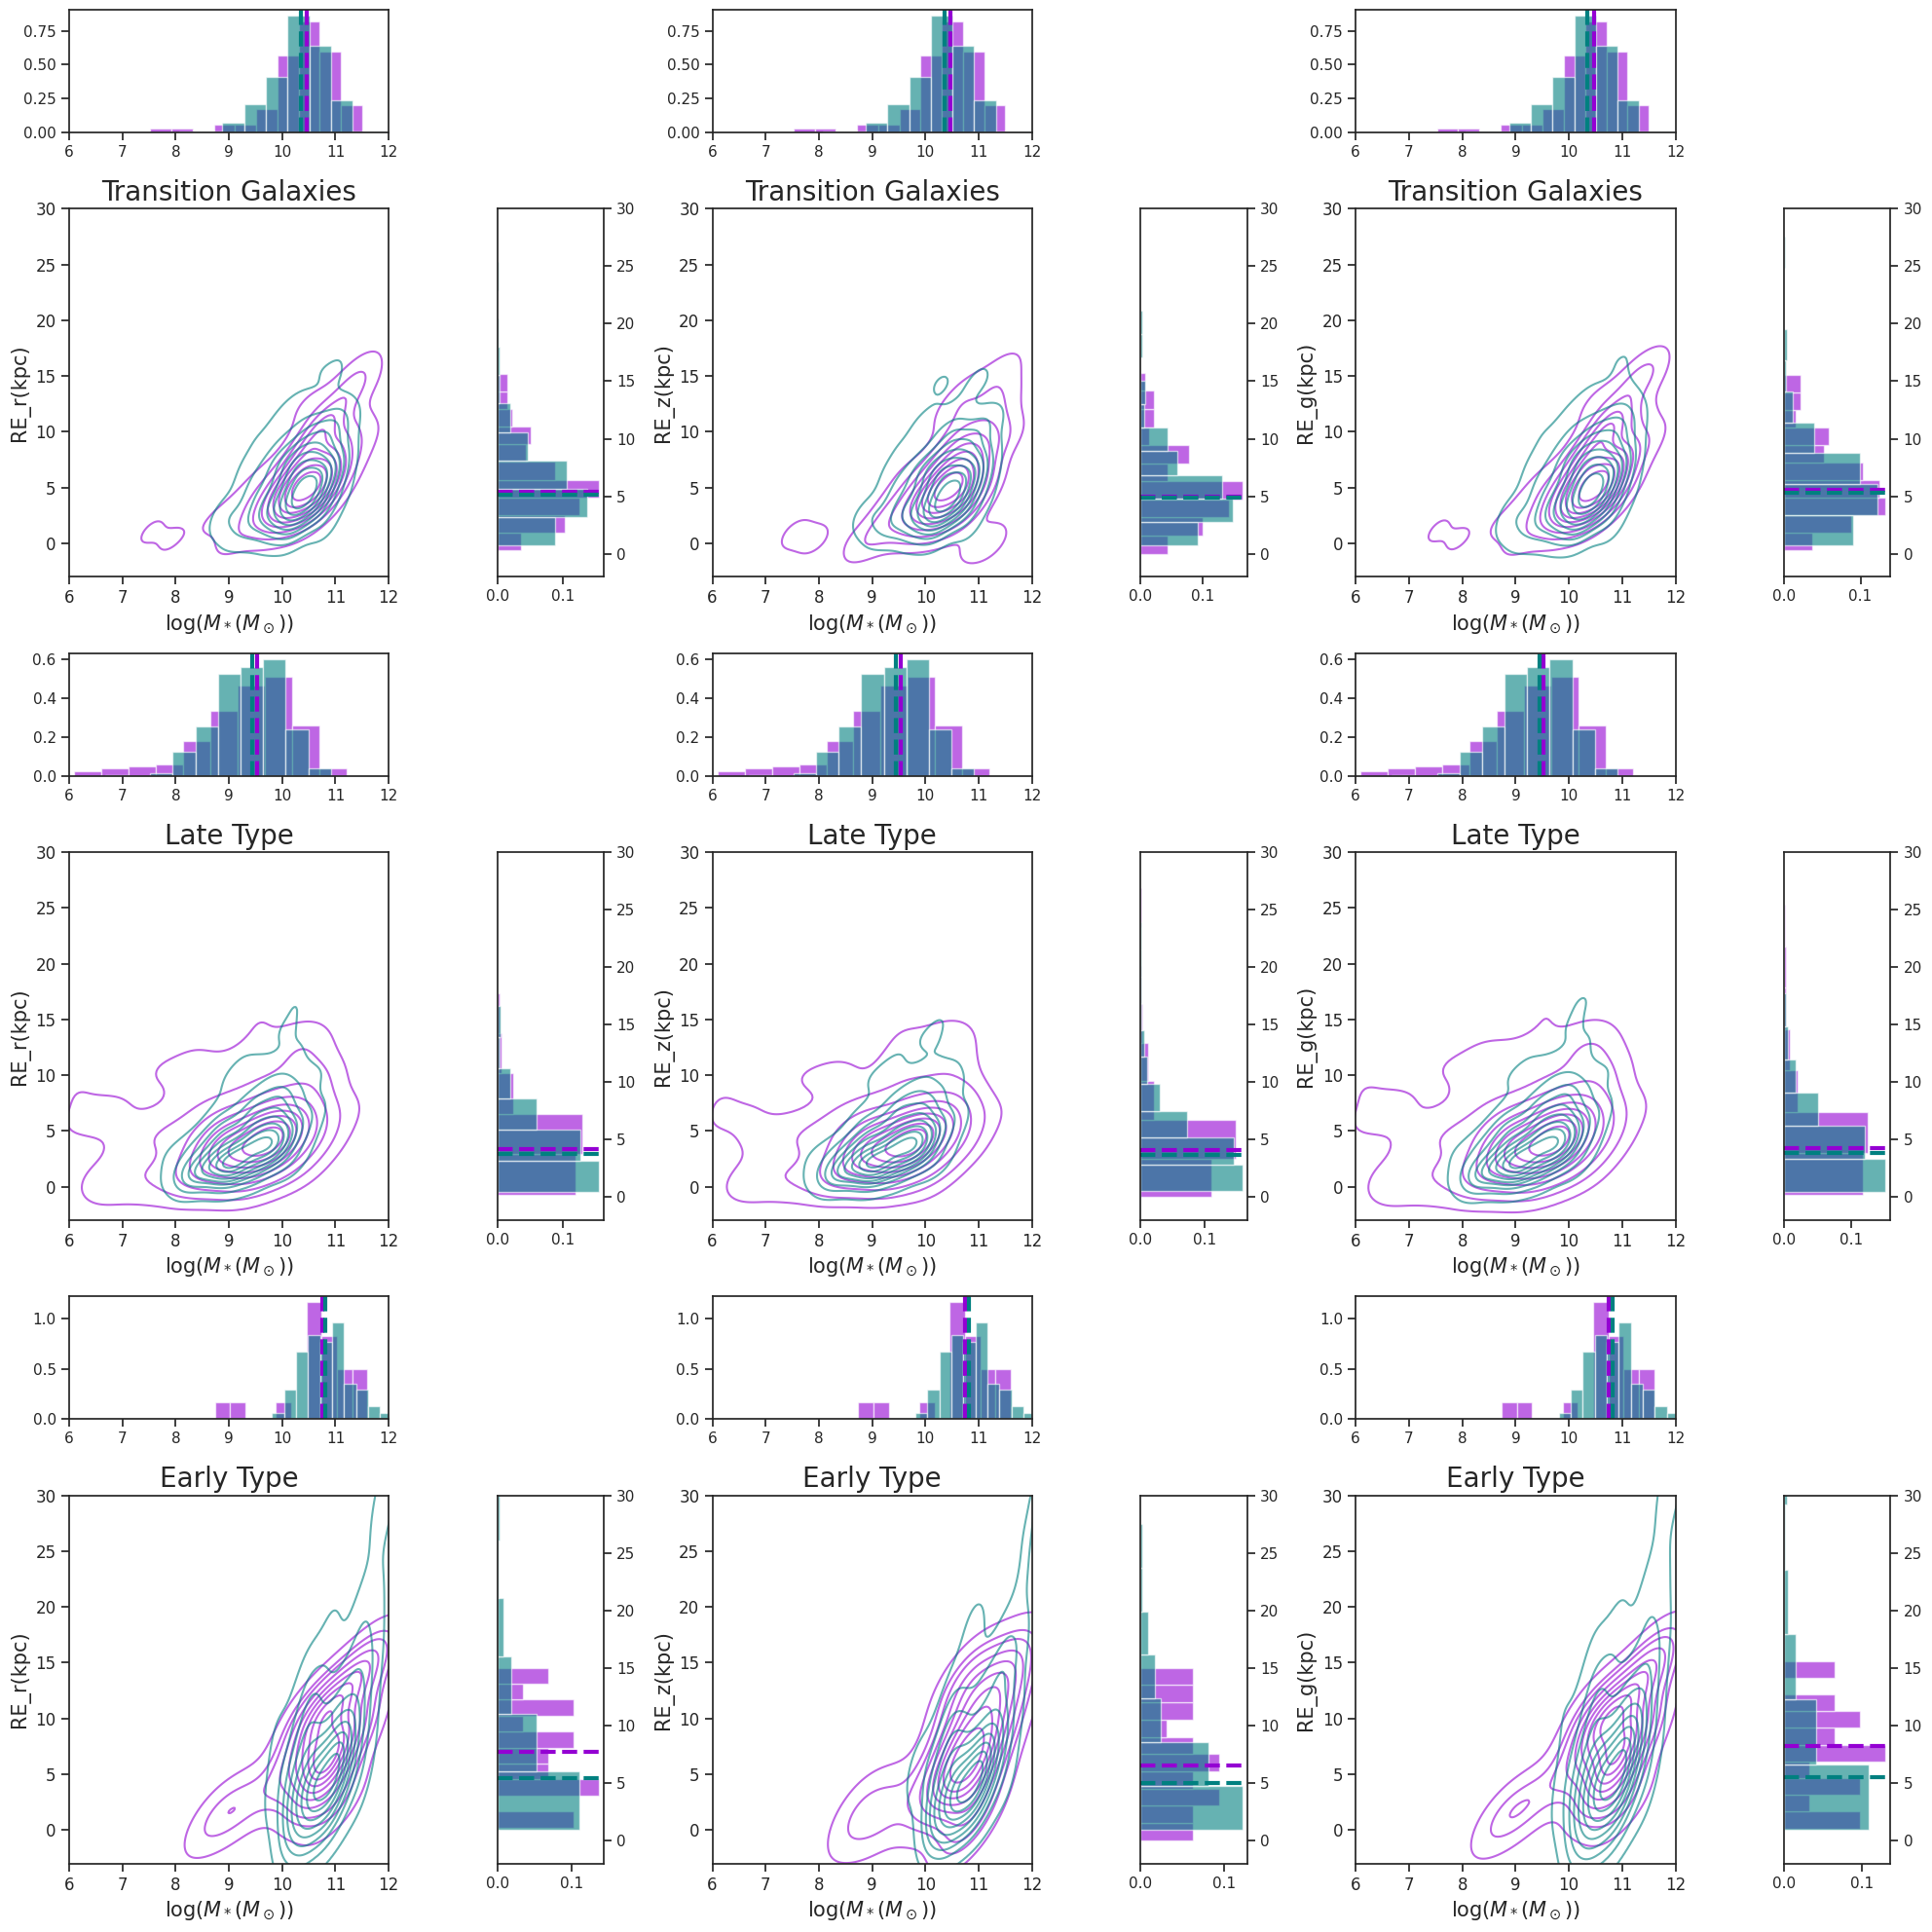

In [37]:
# Diccionario con los tipos de galaxias
galaxy_types = {'Early Type': early_type, 'Transition Galaxies': transition, 'Late Type': late_type}

# Colores para los dos tipos de galaxias
color_map = {'SFCG Galaxy': 'darkviolet', 'Field Galaxy': 'teal'}

# Figuras y ejes
fig, axs = plt.subplots(6, 6, figsize=(20, 20), gridspec_kw={'width_ratios': [6, 2, 6, 2, 6, 2], 'height_ratios': [2, 6, 2, 6, 2, 6]})

# Iterar sobre cada tipo de galaxia y cada columna de Re (g, r, z)
for i, (name, data) in enumerate(galaxy_types.items()):
    for j, re_col in enumerate(['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']):
        ax = axs[2*i-1, 2*j-2]
        ax_histx = axs[2*i-2, 2*j-2] #Panel del histograma en x
        ax_histy = axs[2*i-1, 2*j-1] #Panel del histograma en y
        

        ax.set_title(f'{name}', size=20)
        # Dividir los datos por Nature
        for nature_type, color in color_map.items():
            subset = data[data['Nature'] == nature_type]
            
            #Graficando KDE
            kde_plot = sns.kdeplot(x=subset['stellar_mass_phot_i'], y=subset[re_col], ax=ax, fill=False, color=color, alpha = 0.6, label=nature_type)
            
            # Calcular medianas
            median_x = np.median(subset['stellar_mass_phot_i'])
            median_y = np.median(subset[re_col])
            
            #Histogramas
            ax_histx.hist(subset['stellar_mass_phot_i'], bins=10, color=color, alpha=0.6, density=True)
            ax_histy.hist(subset[re_col], bins=10, color=color, alpha=0.6, orientation='horizontal', density=True)
        
            # Añadir líneas de la mediana
            ax_histx.axvline(median_x, color=color, linestyle='--', linewidth=3)
            ax_histy.axhline(median_y, color=color, linestyle='--', linewidth=3)
        
        # Personalización de ejes
        ax_histx.set_xlim(6, 12)
        ax_histy.set_ylim(-2, 30)
        ax_histy.yaxis.set_label_position("left")
        ax_histy.yaxis.tick_right()
        # Etiquetas personalizadas de los ejes
        ax.set_xlabel(f'log($M_*(M_\odot)$)', size=15)
        ax.set_ylabel(f'{re_col}', size=15)
        ax.set_xlim(6, 12)
        ax.set_ylim(-3, 30)
        # Cambiar el tamaño de las etiquetas de los ticks
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels, title='Galaxy Type', loc='upper left')
# Eliminar los ejes innecesarios (las filas 1, 3 y 5, columnas 2, 4 y 6)
for i in [0, 2, 4]:
    for j in [1, 3, 5]:
        axs[i, j].set_visible(False)
# Configuración global
plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)  # Reducir espacios entre subplots

plt.show()

In [38]:
median_re_late_sfcg = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_re_late_sfcg = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_re_transition_sfcg = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_error_re_transition_sfcg = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_re_early_sfcg = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_re_early_sfcg = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])

median_re_late_cs = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_error_re_late_cs = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_re_transition_cs = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_error_re_transition_cs = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_re_early_cs = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])
median_error_re_early_cs = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])

median_n_late_sfcg = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_n_late_sfcg = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_n_transition_sfcg = np.nanmedian(transition['n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_error_n_transition_sfcg = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_n_early_sfcg = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_n_early_sfcg = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'SFCG Galaxy'])

median_n_late_cs = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'Field Galaxy'])
median_error_n_late_cs = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'Field Galaxy'])
median_n_transition_cs = np.nanmedian(transition['n_r'][transition['Nature'] == 'Field Galaxy'])
median_error_n_transition_cs = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'Field Galaxy'])
median_n_early_cs = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'Field Galaxy'])
median_error_n_early_cs = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'Field Galaxy'])

print(f'Median effective radius for late type SFCG galaxies: {median_re_late_sfcg} \u00B1 {median_error_re_late_sfcg}')
print(f'Median effective radius for late type Field galaxies: {median_re_late_cs} \u00B1 {median_error_re_late_cs}')

print(f'Median effective radius for transition SFCG galaxies: {median_re_transition_sfcg} \u00B1 {median_error_re_transition_sfcg}')
print(f'Median effective radius for transition Field galaxies: {median_re_transition_cs} \u00B1 {median_error_re_transition_cs}')

print(f'Median effective radius for early type SFCG galaxies: {median_re_early_sfcg} \u00B1 {median_error_re_early_sfcg}')
print(f'Median effective radius for early type Field galaxies: {median_re_early_cs} \u00B1 {median_error_re_early_cs}')

print(f'Median Sérsic Index for late type SFCG galaxies: {median_n_late_sfcg} \u00B1 {median_error_n_late_sfcg}')
print(f'Median Sérsic Index for late type Field galaxies: {median_n_late_cs} \u00B1 {median_error_n_late_cs}')

print(f'Median Sérsic Index for transition SFCG galaxies: {median_n_transition_sfcg} \u00B1 {median_error_n_transition_sfcg}')
print(f'Median Sérsic Index for transition Field galaxies: {median_n_transition_cs} \u00B1 {median_error_n_transition_cs}')

print(f'Median Sérsic Index for early type SFCG galaxies: {median_n_early_sfcg} \u00B1 {median_error_n_early_sfcg}')
print(f'Median Sérsic Index for early type Field galaxies: {median_n_early_cs} \u00B1 {median_error_n_early_cs}')


Median effective radius for late type SFCG galaxies: 4.176897572272597 ± 0.00464419921335098
Median effective radius for late type Field galaxies: 3.749864416874349 ± 0.003669853414491355
Median effective radius for transition SFCG galaxies: 5.369450110824419 ± 0.003716553444076471
Median effective radius for transition Field galaxies: 5.0920461083272714 ± 0.005321315719795507
Median effective radius for early type SFCG galaxies: 7.668952500399755 ± 0.012794367529137885
Median effective radius for early type Field galaxies: 5.379365439621656 ± 0.01470567535741129
Median Sérsic Index for late type SFCG galaxies: 1.0974 ± 0.0023
Median Sérsic Index for late type Field galaxies: 1.10335 ± 0.0018
Median Sérsic Index for transition SFCG galaxies: 1.3097 ± 0.0013
Median Sérsic Index for transition Field galaxies: 1.2673 ± 0.0021
Median Sérsic Index for early type SFCG galaxies: 3.6282 ± 0.004
Median Sérsic Index for early type Field galaxies: 4.30325 ± 0.0112


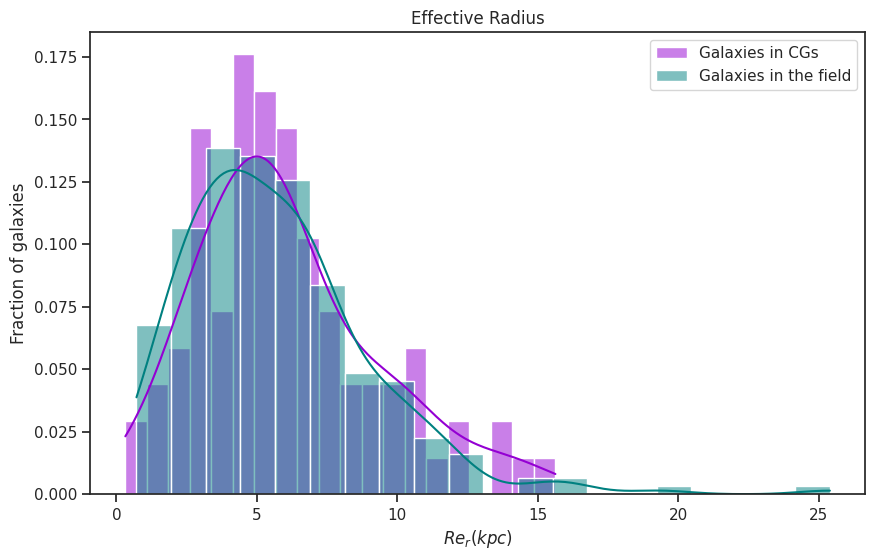

0.09942253458077802 0.49667016839616984


In [39]:
re_late_sfcg = transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy']
re_late_cs = transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(re_late_sfcg.min(), re_late_cs.min()), 
                        max(re_late_sfcg.max(), re_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(re_late_sfcg, kde=True, stat='density', alpha=0.5, bins=20, color='darkviolet', label='Galaxies in CGs')
sns.histplot(re_late_cs, kde=True, stat='density', alpha=0.5, bins=20, color='teal', label='Galaxies in the field')

# Etiquetas y título
plt.xlabel('$Re_{r} (kpc)$')
plt.ylabel('Fraction of galaxies')
plt.title('Effective Radius')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(re_late_sfcg, re_late_cs)
print(ks_stat, p_value)

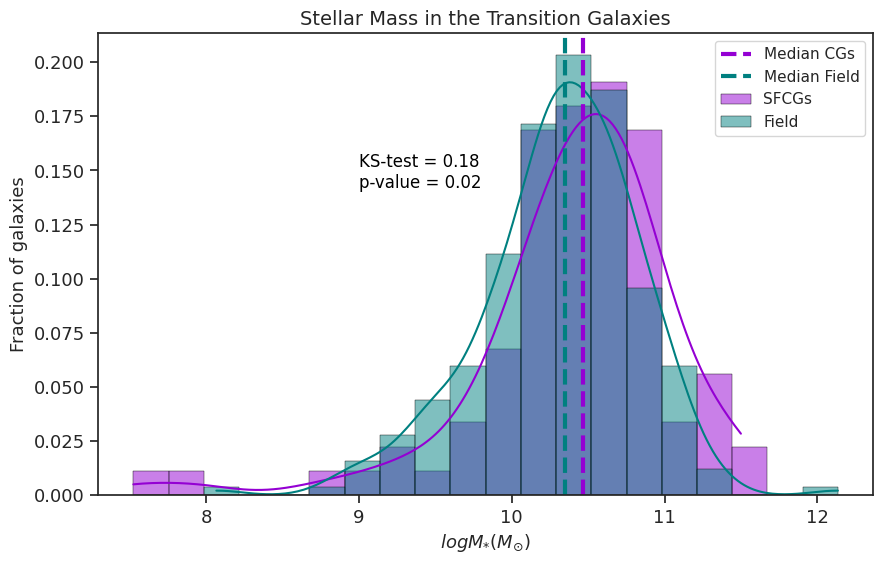

0.16594296969425668 0.04668497828749692


In [52]:
mass_transition_sfcg = transition['stellar_mass_phot_i'][transition['Nature'] == 'SFCG Galaxy']
mass_transition_cs = transition['stellar_mass_phot_i'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(mass_transition_sfcg.min(), mass_transition_cs.min()), 
                        max(mass_transition_sfcg.max(), mass_transition_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass_transition_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(mass_transition_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.median(mass_transition_sfcg)
median_x_2 = np.median(mass_transition_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median CGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')
# Añadir texto al gráfico
plt.text(9, 0.15, 'KS-test = 0.18', color='black', fontsize=12, verticalalignment='bottom')
plt.text(9, 0.14, 'p-value = 0.02', color='black', fontsize=12, verticalalignment='bottom')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$', size=13)
plt.ylabel('Fraction of galaxies', size=13)
plt.title('Stellar Mass in the Transition Galaxies', size=14)
plt.xticks(size=13)
plt.yticks(size=13)

plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_transition_sfcg, mass_transition_cs)
print(ks_stat, p_value)

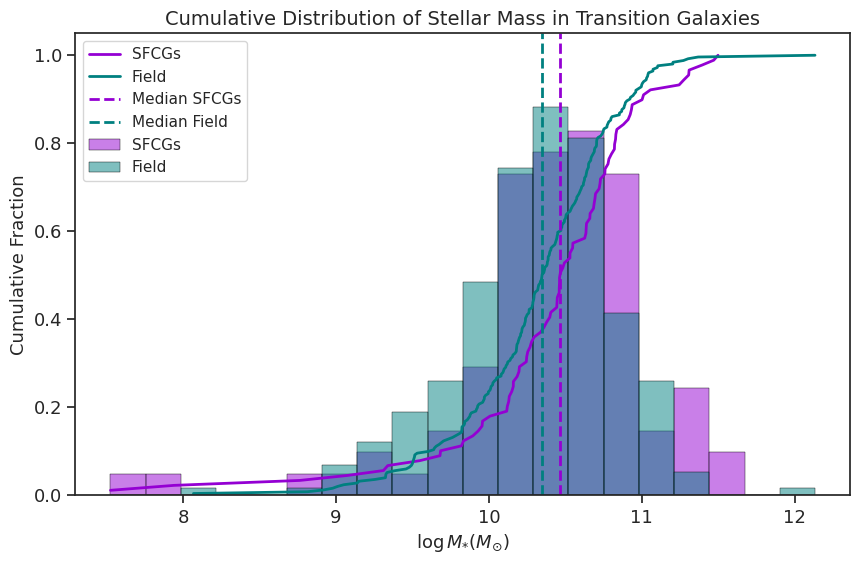

KS-test = 0.17, p-value = 0.0467


In [56]:
# Filtrar datos
mass_transition_sfcg = transition['stellar_mass_phot_i'][transition['Nature'] == 'SFCG Galaxy']
mass_transition_cs = transition['stellar_mass_phot_i'][transition['Nature'] == 'Field Galaxy']

# Ordenar datos y calcular CDF manualmente
mass_sfcg_sorted = np.sort(mass_transition_sfcg)
mass_cs_sorted = np.sort(mass_transition_cs)

cdf_sfcg = np.arange(1, len(mass_sfcg_sorted) + 1) / len(mass_sfcg_sorted)
cdf_cs = np.arange(1, len(mass_cs_sorted) + 1) / len(mass_cs_sorted)

# Crear la figura
plt.figure(figsize=(10, 6))
sns.histplot(mass_transition_sfcg, kde=False, stat='density', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(mass_transition_cs, kde=False, stat='density', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)
# Graficar la CDF manualmente con plt.plot()
plt.plot(mass_sfcg_sorted, cdf_sfcg, color='darkviolet', linewidth=2, label='SFCGs')
plt.plot(mass_cs_sorted, cdf_cs, color='teal', linewidth=2, label='Field')

# Medianas
median_x = np.median(mass_transition_sfcg)
median_x_2 = np.median(mass_transition_cs)

plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=2, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=2, label='Median Field')

# Etiquetas y título
plt.xlabel('$\log M_{*}(M_{\odot})$', size=13)
plt.ylabel('Cumulative Fraction', size=13)
plt.title('Cumulative Distribution of Stellar Mass in Transition Galaxies', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_transition_sfcg, mass_transition_cs)
print(f"KS-test = {ks_stat:.2f}, p-value = {p_value:.4f}")


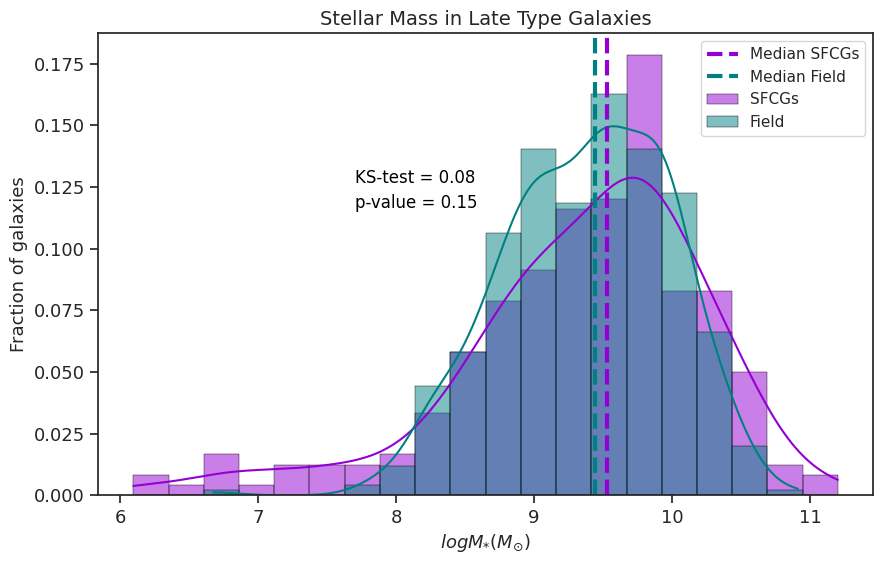

0.08672032528454066 0.16123033084040542


In [41]:
mass_late_sfcg = late_type['stellar_mass_phot_i'][late_type['Nature'] == 'SFCG Galaxy']
mass_late_cs = late_type['stellar_mass_phot_i'][late_type['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(mass_late_sfcg.min(), mass_late_cs.min()), 
                        max(mass_late_sfcg.max(), mass_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass_late_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(mass_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.median(mass_late_sfcg)
median_x_2 = np.median(mass_late_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')
# Añadir texto al gráfico
plt.text(7.7, 0.125, 'KS-test = 0.08', color='black', fontsize=12, verticalalignment='bottom')
plt.text(7.7, 0.115, 'p-value = 0.15', color='black', fontsize=12, verticalalignment='bottom')
# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$', size=13)
plt.ylabel('Fraction of galaxies', size=13)
plt.title('Stellar Mass in Late Type Galaxies', size=14)
plt.xticks(size=13)
plt.yticks(size=13)

plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_late_sfcg, mass_late_cs)
print(ks_stat, p_value)

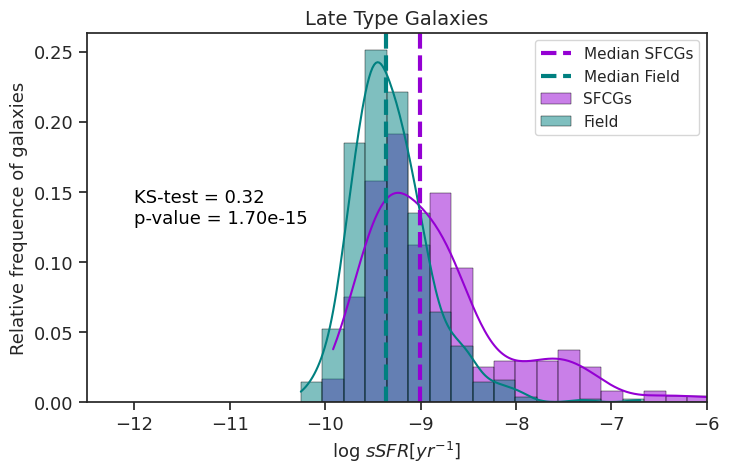

0.32269326267726506 1.7037127411197e-15


In [66]:
ssfr_late_sfcg = late_type['log_sSFR'][late_type['Nature'] == 'SFCG Galaxy']
ssfr_late_cs = late_type['log_sSFR'][late_type['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(ssfr_late_sfcg.min(), ssfr_late_cs.min()), 
                        max(ssfr_late_sfcg.max(), ssfr_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(8, 4.8))
sns.histplot(ssfr_late_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.median(ssfr_late_sfcg)
median_x_2 = np.median(ssfr_late_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')
# Añadir texto al gráfico
plt.text(-12, 0.14, 'KS-test = 0.32', color='black', fontsize=13, verticalalignment='bottom')
plt.text(-12, 0.125, 'p-value = 1.70e-15', color='black', fontsize=13, verticalalignment='bottom')
# Etiquetas y título
plt.xlabel('log $sSFR [yr^{-1}]$', size=13)
plt.ylabel('Relative frequence of galaxies', size=13)
plt.title('Late Type Galaxies', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlim(-12.5, -6)

plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(ssfr_late_sfcg, ssfr_late_cs)
print(ks_stat, p_value)

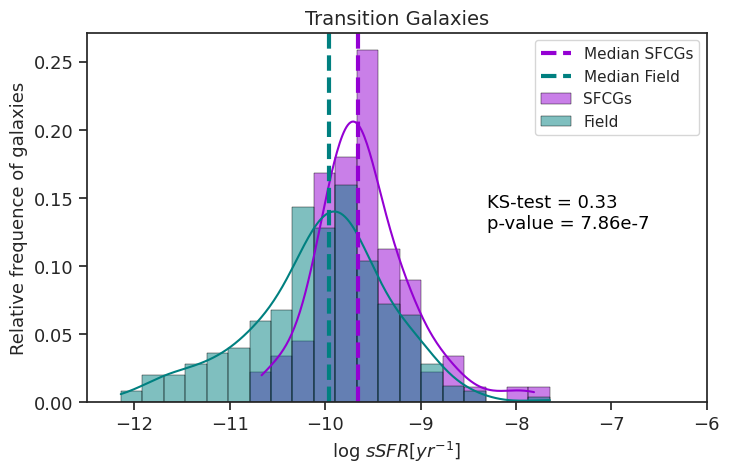

0.3291552889565334 7.856645969205824e-07


In [67]:
ssfr_late_sfcg = transition['log_sSFR'][transition['Nature'] == 'SFCG Galaxy']
ssfr_late_cs = transition['log_sSFR'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(ssfr_late_sfcg.min(), ssfr_late_cs.min()), 
                        max(ssfr_late_sfcg.max(), ssfr_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(8, 4.8))
sns.histplot(ssfr_late_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.median(ssfr_late_sfcg)
median_x_2 = np.median(ssfr_late_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')
# Añadir texto al gráfico
plt.text(-8.3, 0.14, 'KS-test = 0.33', color='black', fontsize=13, verticalalignment='bottom')
plt.text(-8.3, 0.125, 'p-value = 7.86e-7', color='black', fontsize=13, verticalalignment='bottom')
# Etiquetas y título
plt.xlabel('log $sSFR [yr^{-1}]$', size=13)
plt.ylabel('Relative frequence of galaxies', size=13)
plt.title('Transition Galaxies', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlim(-12.5, -6)


plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(ssfr_late_sfcg, ssfr_late_cs)
print(ks_stat, p_value)

In [42]:
cg_cs_filtered = cg_cs[cg_cs['logSFR_NUV'] != np.inf]

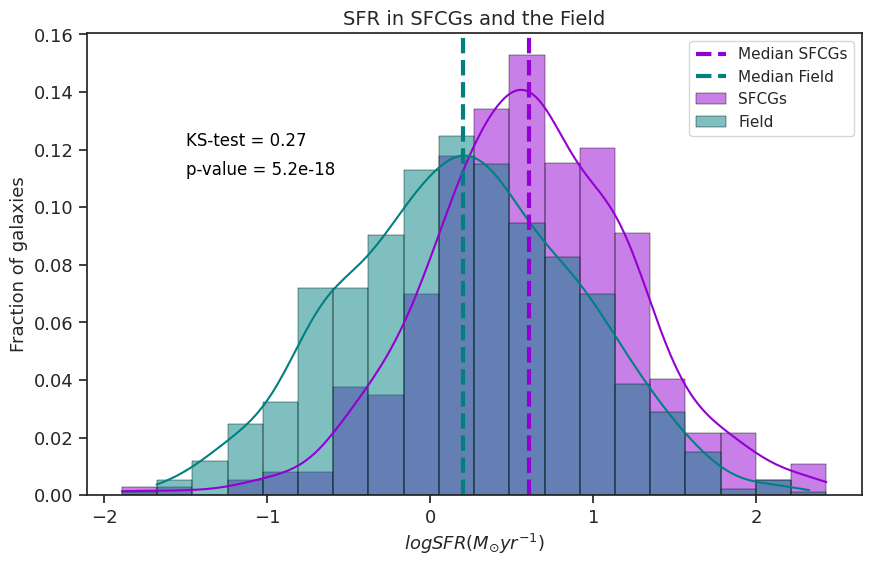

0.27330870262596363 5.1994254380695295e-18
0.6070640635075151 0.2001986541680303


In [43]:
sfr_sfcg = cg_cs_filtered['logSFR_NUV'][cg_cs_filtered['Nature'] == 'SFCG Galaxy']
sfr_cs = cg_cs_filtered['logSFR_NUV'][cg_cs_filtered['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(sfr_sfcg.min(), sfr_cs.min()), 
                        max(sfr_sfcg.max(), sfr_cs.max()), 
                        21)
#bin_edges = 20
# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(sfr_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.nanmedian(sfr_sfcg)
median_x_2 = np.nanmedian(sfr_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')

# Añadir texto al gráfico
plt.text(-1.5, 0.12, 'KS-test = 0.27', color='black', fontsize=12, verticalalignment='bottom')
plt.text(-1.5, 0.11, 'p-value = 5.2e-18', color='black', fontsize=12, verticalalignment='bottom')

# Etiquetas y título
plt.xlabel('$log SFR (M_{\odot}yr^{-1})$', size=13)
plt.ylabel('Fraction of galaxies', size=13)
plt.title('SFR in SFCGs and the Field', size=14)
plt.xticks(size=13)
plt.yticks(size=13)

plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(sfr_sfcg, sfr_cs)
print(ks_stat, p_value)
print(median_x, median_x_2)

In [44]:
cg_cs['Compactness'] = cg_cs['stellar_mass_phot_i']-1.5*np.log10(cg_cs['RE_r(kpc)'])

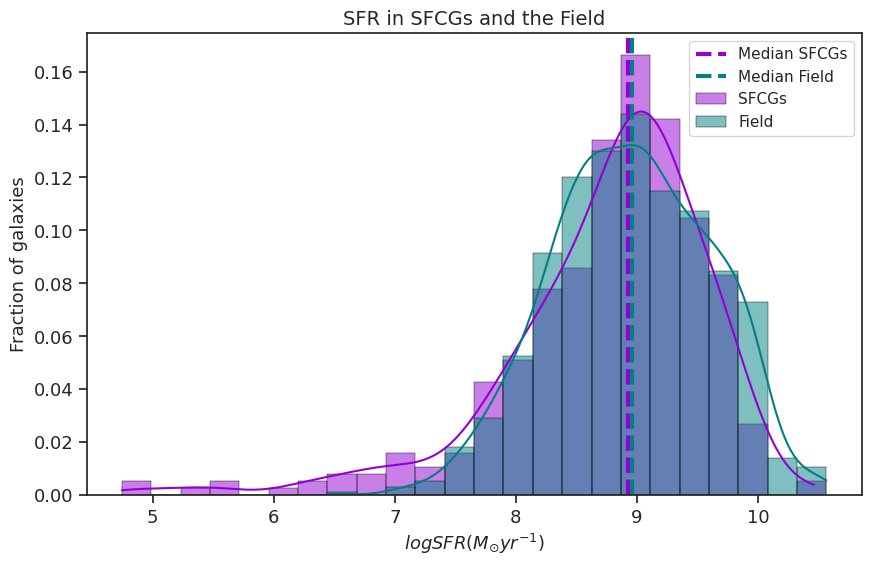

In [45]:
compactness_sfcg = cg_cs['Compactness'][cg_cs['Nature'] == 'SFCG Galaxy']
compactness_cs = cg_cs['Compactness'][cg_cs['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(compactness_sfcg.min(), compactness_cs.min()), 
                        max(compactness_sfcg.max(), compactness_cs.max()), 
                        25)
#bin_edges = 20
# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(compactness_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(compactness_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.nanmedian(compactness_sfcg)
median_x_2 = np.nanmedian(compactness_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')

# Añadir texto al gráfico
#plt.text(-1.2, 0.11, 'KS-test = 0.27', color='black', fontsize=12, verticalalignment='bottom')
#plt.text(-1.2, 0.1, 'p-value = 5.2e-18', color='black', fontsize=12, verticalalignment='bottom')

# Etiquetas y título
plt.xlabel('$log SFR (M_{\odot}yr^{-1})$', size=13)
plt.ylabel('Fraction of galaxies', size=13)
plt.title('SFR in SFCGs and the Field', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
#plt.xlim(0, 10)

plt.legend()

plt.show()

# Realizar el KS test
#ks_stat, p_value = ks_2samp(compactness_sfcg, compactness_cs)
#print(ks_stat, p_value)
#print(median_x, median_x_2)

In [46]:
def bootstrap_mediana(valores, num_bootstrap=1000):
    """
    Calcula la mediana y el error de la mediana usando bootstrap.
    
    :param valores: array-like, valores sobre los que se calcula la mediana.
    :param num_bootstrap: int, número de muestras bootstrap.
    :return: mediana_bootstrap, error_bootstrap
    """
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    if len(valores_filtrados) == 0:
        print("NO HAY VALORES QUE CALCULAR")
        return np.nan, np.nan
    
    # Crear muestras bootstrap
    medianas_bootstrap = []
    for _ in range(num_bootstrap):
        muestra = np.random.choice(valores_filtrados, size=len(valores_filtrados), replace=True)
        medianas_bootstrap.append(np.nanmedian(muestra))
    
    # Calcular estadística final
    mediana_bootstrap = np.nanmedian(medianas_bootstrap)
    error_bootstrap = np.std(medianas_bootstrap)  # Puede usarse también el percentil para intervalos de confianza
    return mediana_bootstrap, error_bootstrap

In [47]:
tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other', 'All']

tablas = [early_type, late_type, transition, other, cg_cs]

for tabla, name in zip(tablas, tabla_names):
    tabla_sfcg = tabla[tabla['Nature'] == 'SFCG Galaxy']
    tabla_cs = tabla[tabla['Nature'] == 'Field Galaxy']
    
    sfr_sfcg = tabla_sfcg['logSFR_NUV']
    sfr_cs = tabla_cs['logSFR_NUV']
    
    ssfr_sfcg = tabla_sfcg['log_sSFR']
    ssfr_cs = tabla_cs['log_sSFR']
    
    mass_sfcg = tabla_sfcg['stellar_mass_phot_i']
    mass_cs = tabla_cs['stellar_mass_phot_i']
    
    median_sfr_sfcg, error_sfr_sfcg = bootstrap_mediana(sfr_sfcg)
    median_sfr_cs, error_sfr_cs = bootstrap_mediana(sfr_cs)
    
    median_ssfr_sfcg, error_ssfr_sfcg = bootstrap_mediana(ssfr_sfcg)
    median_ssfr_cs, error_ssfr_cs = bootstrap_mediana(ssfr_cs)

    median_mass_sfcg, error_mass_sfcg = bootstrap_mediana(mass_sfcg)
    median_mass_cs, error_mass_cs = bootstrap_mediana(mass_cs)

    print(f'Median SFR in SFCGs for {name}: {median_sfr_sfcg:.2f} ± {error_sfr_sfcg:.2f}')
    print(f'Median SFR in CS for {name}: {median_sfr_cs:.2f} ± {error_sfr_cs:.2f}')

    print(f'Median sSFR in SFCGs for {name}: {median_ssfr_sfcg:.2f} ± {error_ssfr_sfcg:.2f}')
    print(f'Median sSFR in CS for {name}: {median_ssfr_cs:.2f} ± {error_ssfr_cs:.2f}')

    print(f'Median Mass in SFCGs for {name}: {median_mass_sfcg:.2f} ± {error_mass_sfcg:.2f}')
    print(f'Median Mass in CS for {name}: {median_mass_cs:.2f} ± {error_mass_cs:.2f}')

Median SFR in SFCGs for Early Type: 0.85 ± 0.20
Median SFR in CS for Early Type: 0.40 ± 0.09
Median sSFR in SFCGs for Early Type: -9.91 ± 0.21
Median sSFR in CS for Early Type: -10.35 ± 0.12
Median Mass in SFCGs for Early Type: 10.75 ± 0.11
Median Mass in CS for Early Type: 10.82 ± 0.06
Median SFR in SFCGs for Late Type: 0.49 ± 0.05
Median SFR in CS for Late Type: 0.07 ± 0.04
Median sSFR in SFCGs for Late Type: -9.00 ± 0.07
Median sSFR in CS for Late Type: -9.36 ± 0.03
Median Mass in SFCGs for Late Type: 9.53 ± 0.08
Median Mass in CS for Late Type: 9.44 ± 0.03
Median SFR in SFCGs for Transition: 0.78 ± 0.08
Median SFR in CS for Transition: 0.34 ± 0.06
Median sSFR in SFCGs for Transition: -9.65 ± 0.04
Median sSFR in CS for Transition: -9.96 ± 0.05
Median Mass in SFCGs for Transition: 10.47 ± 0.06
Median Mass in CS for Transition: 10.35 ± 0.03
Median SFR in SFCGs for Other: 0.31 ± 0.30
Median SFR in CS for Other: 0.35 ± 0.18
Median sSFR in SFCGs for Other: -9.09 ± 0.21
Median sSFR in CS 

-9.003303176064549 -9.358324666705684 0.35502149064113553
0.32269326267726506 1.7037127411197e-15


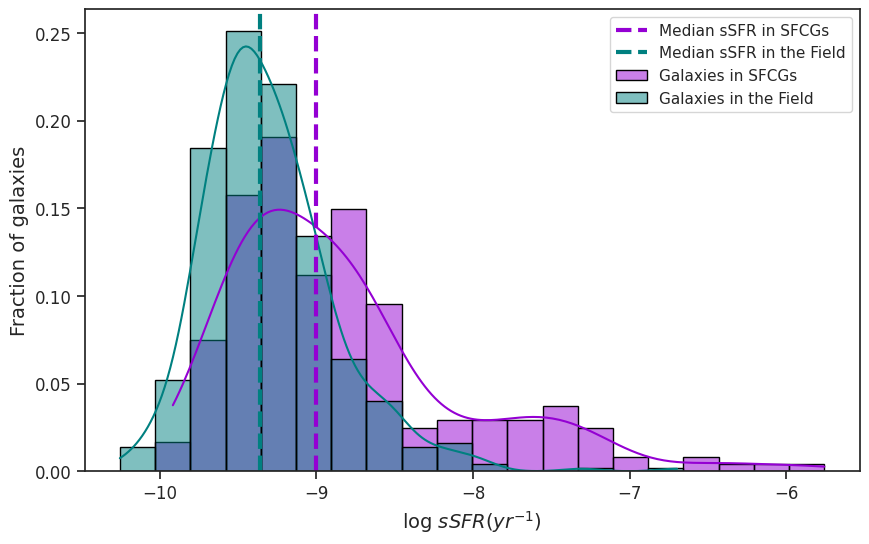

In [48]:
ssfr_sfcg = late_type['log_sSFR'][late_type['Nature'] == 'SFCG Galaxy']
ssfr_cs = late_type['log_sSFR'][late_type['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(ssfr_sfcg.min(), ssfr_cs.min()), 
                        max(ssfr_sfcg.max(), ssfr_cs.max()), 
                        21)# Crear los histogramas con los mismos bordes de bins

plt.figure(figsize=(10, 6))
sns.histplot(ssfr_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in SFCGs', edgecolor='black')
sns.histplot(ssfr_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the Field', edgecolor='black')

# Calcular medianas
median_x = np.median(ssfr_sfcg)
median_x_2 = np.median(ssfr_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median sSFR in SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label=f'Median sSFR in the Field')

# Etiquetas y título
plt.xlabel('log $sSFR (yr^{-1})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, median_x_2, abs(median_x-median_x_2))
# Realizar el KS test
ks_stat, p_value = ks_2samp(ssfr_sfcg, ssfr_cs)
print(ks_stat, p_value)
plt.show()

-9.654532913764504 -9.960657295952403 0.3061243821878996
0.3291552889565334 7.856645969205824e-07


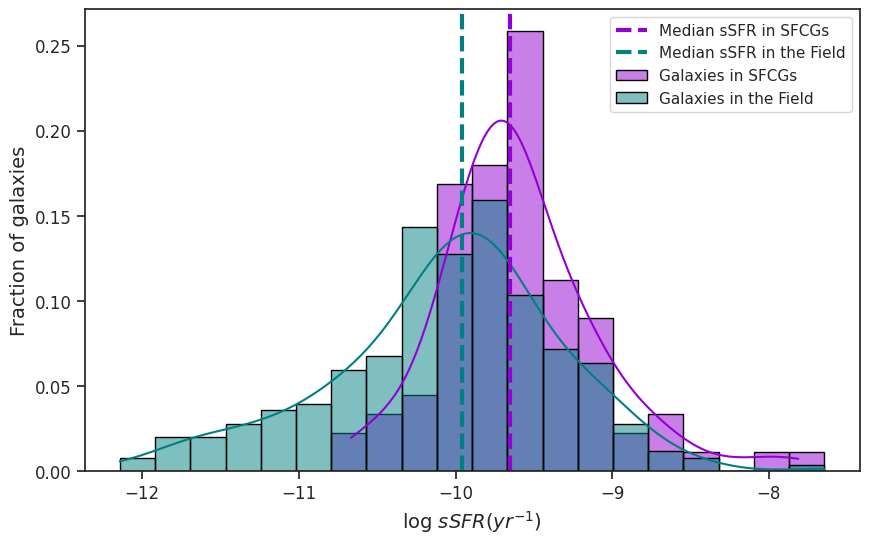

In [49]:
ssfr_sfcg = transition['log_sSFR'][transition['Nature'] == 'SFCG Galaxy']
ssfr_cs = transition['log_sSFR'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(ssfr_sfcg.min(), ssfr_cs.min()), 
                        max(ssfr_sfcg.max(), ssfr_cs.max()), 
                        21)# Crear los histogramas con los mismos bordes de bins

plt.figure(figsize=(10, 6))
sns.histplot(ssfr_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in SFCGs', edgecolor='black')
sns.histplot(ssfr_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the Field', edgecolor='black')

# Calcular medianas
median_x = np.median(ssfr_sfcg)
median_x_2 = np.median(ssfr_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median sSFR in SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label=f'Median sSFR in the Field')

# Etiquetas y título
plt.xlabel('log $sSFR (yr^{-1})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, median_x_2, abs(median_x-median_x_2))
# Realizar el KS test
ks_stat, p_value = ks_2samp(ssfr_sfcg, ssfr_cs)
print(ks_stat, p_value)
plt.show()

-9.90789477158273 -10.350783777648846 0.4428890060661157
0.3778467908902691 0.007632534384063795


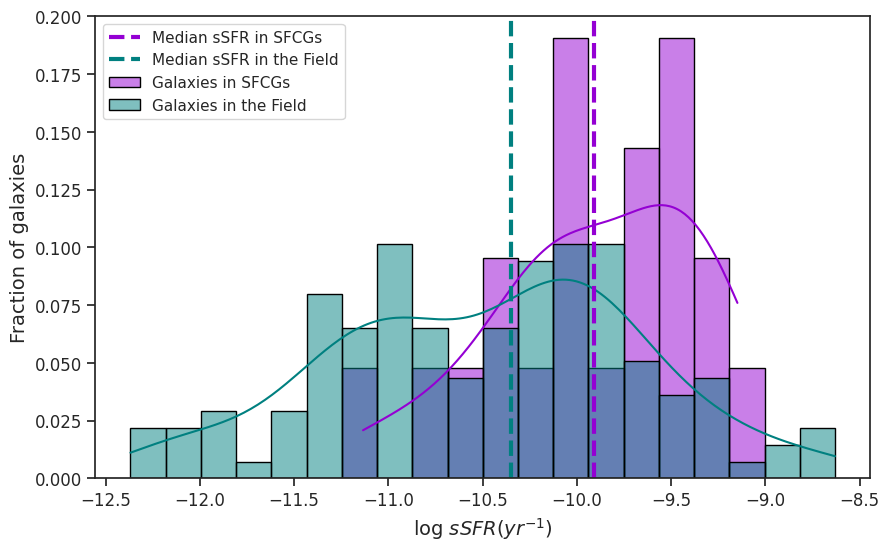

In [50]:
ssfr_sfcg = early_type['log_sSFR'][early_type['Nature'] == 'SFCG Galaxy']
ssfr_cs = early_type['log_sSFR'][early_type['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(ssfr_sfcg.min(), ssfr_cs.min()), 
                        max(ssfr_sfcg.max(), ssfr_cs.max()), 
                        21)# Crear los histogramas con los mismos bordes de bins

plt.figure(figsize=(10, 6))
sns.histplot(ssfr_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in SFCGs', edgecolor='black')
sns.histplot(ssfr_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the Field', edgecolor='black')

# Calcular medianas
median_x = np.median(ssfr_sfcg)
median_x_2 = np.median(ssfr_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median sSFR in SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label=f'Median sSFR in the Field')

# Etiquetas y título
plt.xlabel('log $sSFR (yr^{-1})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, median_x_2, abs(median_x-median_x_2))
# Realizar el KS test
ks_stat, p_value = ks_2samp(ssfr_sfcg, ssfr_cs)
print(ks_stat, p_value)
plt.show()